In [1]:
import os                           # Python version: 3.11.4
import shap                         # Python version: 3.11.4
import itertools                    # Python version: 3.11.4
import torch                        # Version: 2.5.1
import numpy as np                  # Version: 1.24.3
import pandas as pd                 # Version: 1.5.3
import torch.nn as nn               # Torch version: 2.5.1
import matplotlib.pyplot as plt     # Matplotlib version: 3.8.2
import seaborn as sns               # Version: 0.13.2
from torch.utils.data import DataLoader, TensorDataset, RandomSampler # Torch version: 2.5.1
from torchvision import transforms                                    # Torchvision version: 0.20.1
from sklearn.preprocessing import StandardScaler                      # Sklearn version: 1.3.0
from PIL import Image                                                 # PIL version: 9.4.0
from sklearn.model_selection import train_test_split, KFold                   # Sklearn version: 1.3.0
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error # Sklearn version: 1.3.0

In [2]:
# Go from the current notebooks folder to the data folder (target_dir), its file path will be used to import and export data files
notebook_dir = os.getcwd()
parent_dir   = os.path.dirname(notebook_dir)
target_dir   = os.path.join(parent_dir, "data")

In [3]:
# Ensures the training results are the same each time the code is used
seed = 36
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

def worker_init_fn(worker_id):
    np.random.seed(seed + worker_id)

### **STEP 1**: **REAL DATA TRAINING AND FEATURE SELECTION**

#### 1.1 **Prepare Real Training Data**

In [4]:
imp_csv_path      = os.path.join(target_dir, "B_processed_data", "png_files", "resized", "training.csv")
full_training_set = pd.read_csv(imp_csv_path)

# Scale pixel values
transform  = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]) # Normalize to [-1, 1]
])

# training_set
tensor_images_training = []
tensor_training        = []
target_tensor_list     = []
image_folder_path      = os.path.join(target_dir, "B_processed_data", "png_files", "resized", "training")
annotation_folder_path = os.path.join(target_dir, "B_processed_data", "png_files", "resized", "yolo_annotations", "training")
# Fit the scaling of numerical values on training data only
scaler           = StandardScaler()
columns_to_scale = full_training_set.iloc[:, 7:27].columns.tolist() + full_training_set.iloc[:, 4:5].columns.tolist()
scaler.fit(full_training_set[columns_to_scale])
# Fit the scaling of the target variable separately
scaler_target    = StandardScaler()
scaler_target.fit(full_training_set[["Head fresh weight (g)"]])

# Tensor loop
for index, row in full_training_set.iterrows():
    # Images
    filename     = row["New_filename"] 
    image_path   = os.path.join(image_folder_path, filename)
    image        = Image.open(image_path)
    image_tensor = transform(image)
    tensor_images_training.append(image_tensor)
    # Image annotations
    annotation_path = os.path.join(annotation_folder_path, os.path.splitext(filename)[0] + ".txt")
    with open(annotation_path, "r") as file:
        yolo_annotations = file.readlines()
    yolo_annotation = list(map(float, yolo_annotations[0].strip().split()))
    yolo_tensor     = torch.tensor(yolo_annotation, dtype = torch.float32)
    # Numerical data
    numerical_data   = row[columns_to_scale].values.reshape(1, -1)   
    numerical_df     = pd.DataFrame(numerical_data, columns = columns_to_scale)
    scaled_data      = scaler.transform(numerical_df)
    numerical_tensor = torch.tensor(scaled_data, dtype = torch.float32)
    numerical_tensor = numerical_tensor.squeeze()
    # Categorical data
    categorical_columns = ["Crop type", "Water treatment", "Fertiliser treatment", "Bed"]
    categorical_data    = row[categorical_columns]
    categorical_tensor  = torch.tensor(categorical_data, dtype = torch.float32)
    # Combine and store
    variable_vector = torch.cat((numerical_tensor, categorical_tensor, yolo_tensor), dim = 0)
    tensor_training.append(variable_vector)

    # Target variable Head fresh weight (g)
    target        = row[["Head fresh weight (g)"]].values.reshape(1, -1)
    target_df     = pd.DataFrame(target, columns = ["Head fresh weight (g)"])
    scaled_target = scaler_target.transform(target_df).squeeze()
    target_tensor_list.append(torch.tensor(scaled_target, dtype = torch.float32))

training_tensor_images  = torch.stack(tensor_images_training)
training_tensor_vectors = torch.stack(tensor_training)
target_tensor           = torch.stack(target_tensor_list).squeeze()

print(f"Images Tensor Shape:        {training_tensor_images.shape}")
print(f"Conditioning Vectors Shape: {training_tensor_vectors.shape}")
print(f"Targets Tensor Shape:       {target_tensor.shape}")

Images Tensor Shape:        torch.Size([2280, 3, 256, 256])
Conditioning Vectors Shape: torch.Size([2280, 30])
Targets Tensor Shape:       torch.Size([2280])


#### 1.2 **Feature Selection**

Epoch [001/100], Loss: 1.1925, Gradient Norm: 3.7
Epoch [002/100], Loss: 1.1908, Gradient Norm: 3.7
Epoch [003/100], Loss: 1.1891, Gradient Norm: 3.7
Epoch [004/100], Loss: 1.1874, Gradient Norm: 3.7
Epoch [005/100], Loss: 1.1857, Gradient Norm: 3.7
Epoch [006/100], Loss: 1.1841, Gradient Norm: 3.7
Epoch [007/100], Loss: 1.1824, Gradient Norm: 3.7
Epoch [008/100], Loss: 1.1807, Gradient Norm: 3.7
Epoch [009/100], Loss: 1.1790, Gradient Norm: 3.6
Epoch [010/100], Loss: 1.1774, Gradient Norm: 3.6
Epoch [011/100], Loss: 1.1757, Gradient Norm: 3.6
Epoch [012/100], Loss: 1.1741, Gradient Norm: 3.6
Epoch [013/100], Loss: 1.1724, Gradient Norm: 3.6
Epoch [014/100], Loss: 1.1708, Gradient Norm: 3.6
Epoch [015/100], Loss: 1.1692, Gradient Norm: 3.6
Epoch [016/100], Loss: 1.1675, Gradient Norm: 3.6
Epoch [017/100], Loss: 1.1659, Gradient Norm: 3.6
Epoch [018/100], Loss: 1.1643, Gradient Norm: 3.6
Epoch [019/100], Loss: 1.1627, Gradient Norm: 3.6
Epoch [020/100], Loss: 1.1611, Gradient Norm: 3.5


PermutationExplainer explainer: 2281it [00:38, 49.94it/s]                          


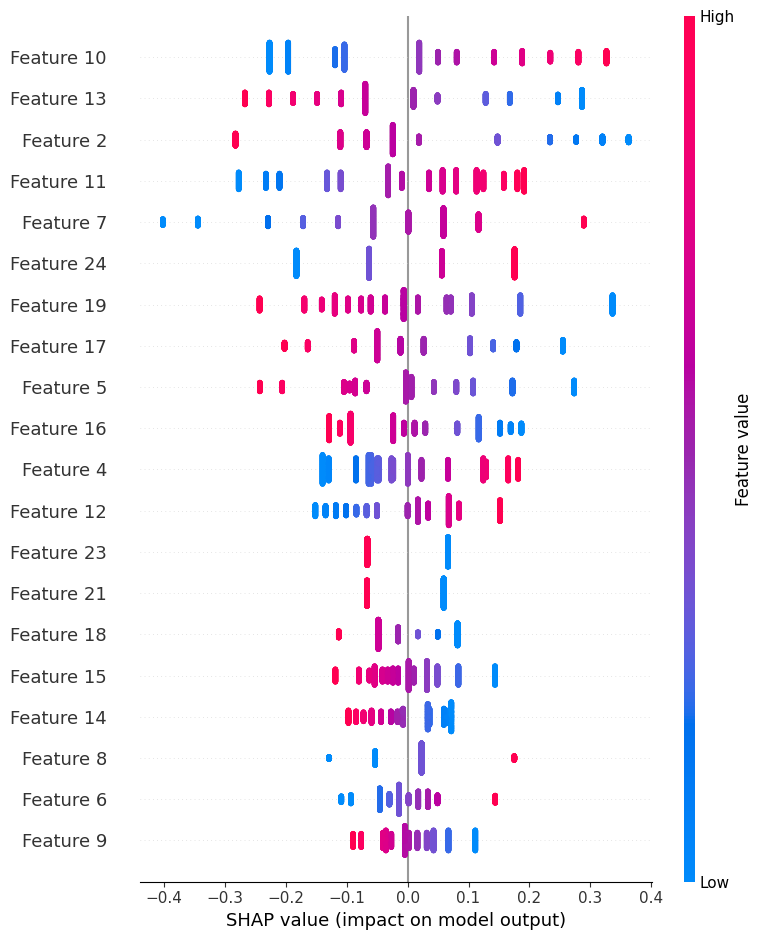

Feature 10: W6_10cm_Dielectric (e)_mean, Mean SHAP Value: 0.1552
Feature 13: W6_10cm_Temperature (C)_std, Mean SHAP Value: 0.1489
Feature 2: W5_10cm_Temperature (C)_mean, Mean SHAP Value: 0.1374
Feature 11: W6_10cm_Temperature (C)_max, Mean SHAP Value: 0.1232
Feature 7: W5_30cm_Temperature (C)_mean, Mean SHAP Value: 0.1198
Feature 24: Bed, Mean SHAP Value: 0.1196
Feature 19: W6_30cm_Volumetric Water Content (%)_sum, Mean SHAP Value: 0.1122
Feature 17: W6_30cm_Temperature (C)_mean, Mean SHAP Value: 0.1006
Feature 5: W5_30cm_Dielectric (e)_mean, Mean SHAP Value: 0.0971
Feature 16: W6_30cm_Temperature (C)_max, Mean SHAP Value: 0.0897
Feature 4: W5_10cm_Volumetric Water Content (%)_sum, Mean SHAP Value: 0.0806
Feature 12: W6_10cm_Temperature (C)_mean, Mean SHAP Value: 0.0787
Feature 23: Fertiliser treatment, Mean SHAP Value: 0.0663
Feature 21: Crop type, Mean SHAP Value: 0.0627
Feature 18: W6_30cm_Temperature (C)_std, Mean SHAP Value: 0.0552
Feature 15: W6_30cm_Dielectric (e)_mean, Mean SH

In [6]:
# Feature importance
class FeatureSelectionModel(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = torch.nn.Linear(input_dim, 1)
    def forward(self, x):
        return self.fc(x)
    
def model_wrapper(inputs):
    tensor_inputs = torch.tensor(inputs, dtype = torch.float32).to(device)
    return model(tensor_inputs).cpu().detach().numpy()

device                  = torch.device("cuda")
training_tensor_vectors = training_tensor_vectors.to(device)
target_tensor           = target_tensor.to(device).view(-1, 1)
# Train the model on vectors and targets
torch.manual_seed(seed)
model     = FeatureSelectionModel(input_dim = training_tensor_vectors.size(1)).to(device)
criterion = torch.nn.MSELoss()
torch.manual_seed(seed)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.1)

fs_dir         = os.path.join(target_dir, "B_processed_data", "png_files", "resized", "training", "feature_selection")
log_file       = os.path.join(fs_dir, "training_log.txt")
shap_plot_file = os.path.join(fs_dir, "shap_plot.txt")
shap_file      = os.path.join(fs_dir, "shap_ranks.txt")

with open(log_file, "w") as f:
    for epoch in range(100):
        optimizer.zero_grad()
        outputs = model(training_tensor_vectors)
        loss    = criterion(outputs, target_tensor)
        loss.backward()
        # Monitor gradient norms
        total_norm = 0
        for param in model.parameters():
            param_norm  = param.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        # Step
        optimizer.step()
        scheduler.step()
        # Log
        log_message = f"Epoch [{(epoch + 1):03}/100], Loss: {loss.item():.4f}, Gradient Norm: {total_norm:.1f}"
        f.write(log_message + "\n")
        print(log_message)

# SHAP analysis
explainer   = shap.Explainer(model_wrapper, training_tensor_vectors.cpu().numpy())
shap_values = explainer(training_tensor_vectors.cpu().numpy())
shap.summary_plot(shap_values, features = training_tensor_vectors.cpu().numpy())

# List of feature names in the same order as training_tensor_vectors
feature_names = columns_to_scale + ["Crop type", "Water treatment", "Fertiliser treatment", "Bed"] + ["YOLO Feature 1", "YOLO Feature 2", "YOLO Feature 3", "YOLO Feature 4", "YOLO Feature 5"]
# Interpret SHAP summary plot
shap_values_array = shap_values.values
mean_shap_values  = np.abs(shap_values_array).mean(axis = 0)
shap_order   = np.argsort(mean_shap_values)[::-1]
shap_ranking = [(f"Feature {shap_order[i]}", feature_names[shap_order[i]], mean_shap_values[shap_order[i]]) for i in range(20)]
# Log
shap_plot_file = os.path.join(fs_dir, "shap_plot_features.txt")
with open(shap_plot_file, "w") as f:
    for feature_number, feature_name, importance in shap_ranking:
        log_message = f"{feature_number}: {feature_name}, Mean SHAP Value: {importance:.4f}"
        f.write(log_message + "\n")
        print(log_message)

print("\n")
# SHAP-ranked feature names
shap_values_array    = shap_values.values
mean_shap_values     = np.abs(shap_values_array).mean(axis = 0)
shap_feature_ranking = list(zip(feature_names, mean_shap_values))
shap_feature_ranking.sort(key = lambda x: x[1], reverse = True) # Sort by SHAP importance
# Log
with open(shap_file, "w") as f:
    for rank, (feature, importance) in enumerate(shap_feature_ranking, 1):
        log_message = f"Rank {rank}: {feature}, Mean SHAP Value: {importance:.4f}"
        f.write(log_message + "\n")
        print(log_message)

In [5]:
feature_names = columns_to_scale + ["Crop type", "Water treatment", "Fertiliser treatment", "Bed"] + ["YOLO Feature 1", "YOLO Feature 2", "YOLO Feature 3", "YOLO Feature 4", "YOLO Feature 5"]

# Remove features
features_to_remove = [
    "W5_10cm_Temperature (C)_std",
    "W5_10cm_Dielectric (e)_mean",
    "Total fresh weight (g)",
    "Water treatment",
    "W5_10cm_Temperature (C)_max",
    "W5_30cm_Volumetric Water Content (%)_sum",
    "W5_30cm_Temperature (C)_max",
    "W5_30cm_Temperature (C)_std",
    "W6_10cm_Volumetric Water Content (%)_sum",
    "W6_30cm_Dielectric (e)_mean"
]
indices_to_remove = [feature_names.index(feature) for feature in features_to_remove]
mask = torch.tensor([i not in indices_to_remove for i in range(training_tensor_vectors.size(1))], dtype = torch.bool)
filtered_training_tensor_vectors = training_tensor_vectors[:, mask]

print(f"Updated vector: {filtered_training_tensor_vectors.shape}")

Updated vector: torch.Size([2280, 20])


In [6]:
# Remove features
features_to_remove = [
    "W5_10cm_Temperature (C)_std",
    "W5_10cm_Dielectric (e)_mean",
    "Total fresh weight (g)",
    "Water treatment",
    "W5_10cm_Temperature (C)_max",
    "W5_30cm_Volumetric Water Content (%)_sum",
    "W5_30cm_Temperature (C)_max",
    "W5_30cm_Temperature (C)_std",
    "W6_10cm_Volumetric Water Content (%)_sum",
    "W6_30cm_Dielectric (e)_mean",
    "YOLO Feature 5",
    "YOLO Feature 4",
    "YOLO Feature 3",
    "YOLO Feature 2",
    "YOLO Feature 1"
]
indices_to_remove = [feature_names.index(feature) for feature in features_to_remove]
mask = torch.tensor([i not in indices_to_remove for i in range(training_tensor_vectors.size(1))], dtype = torch.bool)
filtered_withoutYOLO_training_tensor_vectors = training_tensor_vectors[:, mask]

print(f"Updated vector: {filtered_withoutYOLO_training_tensor_vectors.shape}")

Updated vector: torch.Size([2280, 15])


#### 1.3 **Train 2D-CNN** (Full Features)
Training Results - Loss: 0.0777, MSE: 0.1821, R²: 0.8239

In [11]:
class CNN(nn.Module):
    def __init__(self, conditioning_dim):
        super(CNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 8,  kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm2d(8),  nn.LeakyReLU(negative_slope = 0.01), nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(8, 16, kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm2d(16), nn.LeakyReLU(negative_slope = 0.01), nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Flatten()
        )
        # Adjust output dimensions based on input image size
        self.cnn_output_dim = 16 * 64 * 64 
        # Fully connected layers for combined inputs
        self.fc = nn.Sequential(
            nn.Linear(self.cnn_output_dim + conditioning_dim, 64), nn.LeakyReLU(negative_slope = 0.01), nn.Dropout(0.5),
            nn.Linear(64, 1)
        )
    def forward(self, images, vectors):
        image_features = self.cnn(images)
        combined       = torch.cat((image_features, vectors), dim = 1)
        output         = self.fc(combined)
        return output
    
# Evaluation function
def evaluate_model(model, loader, criterion, device, phase = "Evaluation"):
    model.eval()
    total_loss = 0
    total_mse  = 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for batch_images, batch_vectors, batch_targets in loader:
            batch_images  = batch_images.to(device)
            batch_vectors = batch_vectors.to(device)
            batch_targets = batch_targets.to(device).squeeze()

            predictions = model(batch_images, batch_vectors).squeeze()
            loss        = criterion(predictions, batch_targets)
            total_loss += loss.item()
            total_mse  += mean_squared_error(batch_targets.cpu(), predictions.cpu())

            all_preds.extend(predictions.cpu().numpy())
            all_targets.extend(batch_targets.cpu().numpy())
    avg_loss = total_loss / len(loader)
    avg_mse  = total_mse / len(loader)
    r2       = r2_score(all_targets, all_preds)
    print(f"{phase} Results - Loss: {avg_loss:.4f}, MSE: {avg_mse:.4f}, R²: {r2:.4f}")
    return avg_loss, avg_mse, r2

# Instantiate and compile the model
device    = torch.device("cuda")
torch.manual_seed(seed)
model     = CNN(conditioning_dim = training_tensor_vectors.size(1)).to(device) ### ENSURE CORRECT TENSOR VECTOR
torch.manual_seed(seed)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 50, gamma = 0.5)
criterion_mse   = nn.MSELoss()
criterion_huber = nn.SmoothL1Loss() # Huber loss

# File paths
cnn_dir       = os.path.join(target_dir, "B_processed_data", "png_files", "resized", "training", "CNN_model")
log_file      = os.path.join(cnn_dir, "training_log_F_full.txt")
# Dataset
train_dataset = TensorDataset(training_tensor_images, training_tensor_vectors, target_tensor) ### ENSURE CORRECT TENSOR VECTOR
train_loader  = DataLoader(train_dataset, batch_size = 128, worker_init_fn = worker_init_fn, num_workers = 0, shuffle = False)

# Training loop
with open(log_file, "w") as f:
    for epoch in range(300):
        model.train()
        total_loss = 0
        total_mse  = 0
        for batch_images, batch_vectors, batch_targets in train_loader:
            batch_images  = batch_images.to(device)
            batch_vectors = batch_vectors.to(device)
            batch_targets = batch_targets.to(device).squeeze()
            # Predictions
            optimizer.zero_grad()
            predictions = model(batch_images, batch_vectors).squeeze()
            # Loss
            loss = criterion_huber(predictions, batch_targets)
            loss.backward()
            optimizer.step()
            # Accumulate loss and MSE
            total_loss += loss.item()
            mse         = nn.functional.mse_loss(predictions, batch_targets, reduction = "mean").item()
            total_mse  += mse
        scheduler.step()
        # Log
        avg_loss = total_loss / len(train_loader)
        avg_mse  = total_mse / len(train_loader)
        log_message = f"Epoch [{epoch + 1:03}/300] | Loss: {avg_loss:.4f} | MSE: {avg_mse:.4f}"
        f.write(log_message + "\n")
        print(log_message)

# Final evaluation
train_loss, train_mse, train_r2 = evaluate_model(model, train_loader, criterion_huber, device, phase = "Training")

Epoch [001/300] | Loss: 0.8779 | MSE: 4.8327
Epoch [002/300] | Loss: 0.4123 | MSE: 1.0644
Epoch [003/300] | Loss: 0.4116 | MSE: 1.0693
Epoch [004/300] | Loss: 0.4105 | MSE: 1.0696
Epoch [005/300] | Loss: 0.4041 | MSE: 1.0494
Epoch [006/300] | Loss: 0.4078 | MSE: 1.0607
Epoch [007/300] | Loss: 0.4038 | MSE: 1.0529
Epoch [008/300] | Loss: 0.4041 | MSE: 1.0551
Epoch [009/300] | Loss: 0.4024 | MSE: 1.0468
Epoch [010/300] | Loss: 0.4020 | MSE: 1.0492
Epoch [011/300] | Loss: 0.3985 | MSE: 1.0393
Epoch [012/300] | Loss: 0.3994 | MSE: 1.0416
Epoch [013/300] | Loss: 0.4002 | MSE: 1.0439
Epoch [014/300] | Loss: 0.3958 | MSE: 1.0319
Epoch [015/300] | Loss: 0.3988 | MSE: 1.0444
Epoch [016/300] | Loss: 0.3968 | MSE: 1.0289
Epoch [017/300] | Loss: 0.3956 | MSE: 1.0276
Epoch [018/300] | Loss: 0.3925 | MSE: 1.0219
Epoch [019/300] | Loss: 0.3944 | MSE: 1.0269
Epoch [020/300] | Loss: 0.3929 | MSE: 1.0215
Epoch [021/300] | Loss: 0.3881 | MSE: 1.0107
Epoch [022/300] | Loss: 0.3874 | MSE: 1.0130
Epoch [023

#### 1.4 **Train 2D-CNN** (Reduced Features)
Training Results - Loss: 0.1224, MSE: 0.3365, R²: 0.6723

In [12]:
class CNN(nn.Module):
    def __init__(self, conditioning_dim):
        super(CNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 8,  kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm2d(8),  nn.LeakyReLU(negative_slope = 0.01), nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(8, 16, kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm2d(16), nn.LeakyReLU(negative_slope = 0.01), nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Flatten()
        )
        # Adjust output dimensions based on input image size
        self.cnn_output_dim = 16 * 64 * 64 
        # Fully connected layers for combined inputs
        self.fc = nn.Sequential(
            nn.Linear(self.cnn_output_dim + conditioning_dim, 64), nn.LeakyReLU(negative_slope = 0.01), nn.Dropout(0.5),
            nn.Linear(64, 1)
        )
    def forward(self, images, vectors):
        image_features = self.cnn(images)
        combined       = torch.cat((image_features, vectors), dim = 1)
        output         = self.fc(combined)
        return output
    
# Evaluation function
def evaluate_model(model, loader, criterion, device, phase = "Evaluation"):
    model.eval()
    total_loss = 0
    total_mse  = 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for batch_images, batch_vectors, batch_targets in loader:
            batch_images  = batch_images.to(device)
            batch_vectors = batch_vectors.to(device)
            batch_targets = batch_targets.to(device).squeeze()

            predictions = model(batch_images, batch_vectors).squeeze()
            loss        = criterion(predictions, batch_targets)
            total_loss += loss.item()
            total_mse  += mean_squared_error(batch_targets.cpu(), predictions.cpu())

            all_preds.extend(predictions.cpu().numpy())
            all_targets.extend(batch_targets.cpu().numpy())
    avg_loss = total_loss / len(loader)
    avg_mse  = total_mse / len(loader)
    r2       = r2_score(all_targets, all_preds)
    print(f"{phase} Results - Loss: {avg_loss:.4f}, MSE: {avg_mse:.4f}, R²: {r2:.4f}")
    return avg_loss, avg_mse, r2

# Instantiate and compile the model
device    = torch.device("cuda")
torch.manual_seed(seed)
model     = CNN(conditioning_dim = filtered_training_tensor_vectors.size(1)).to(device) ### ENSURE CORRECT TENSOR VECTOR
torch.manual_seed(seed)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 50, gamma = 0.5)
criterion_mse   = nn.MSELoss()
criterion_huber = nn.SmoothL1Loss() # Huber loss

# File paths
cnn_dir       = os.path.join(target_dir, "B_processed_data", "png_files", "resized", "training", "CNN_model")
log_file      = os.path.join(cnn_dir, "training_log_F_filtered.txt")
# Dataset
train_dataset = TensorDataset(training_tensor_images, filtered_training_tensor_vectors, target_tensor) ### ENSURE CORRECT TENSOR VECTOR
train_loader  = DataLoader(train_dataset, batch_size = 128, worker_init_fn = worker_init_fn, num_workers = 0, shuffle = False)

# Training loop
with open(log_file, "w") as f:
    for epoch in range(300):
        model.train()
        total_loss = 0
        total_mse  = 0
        for batch_images, batch_vectors, batch_targets in train_loader:
            batch_images  = batch_images.to(device)
            batch_vectors = batch_vectors.to(device)
            batch_targets = batch_targets.to(device).squeeze()
            # Predictions
            optimizer.zero_grad()
            predictions = model(batch_images, batch_vectors).squeeze()
            # Loss
            loss = criterion_huber(predictions, batch_targets)
            loss.backward()
            optimizer.step()
            # Accumulate loss and MSE
            total_loss += loss.item()
            mse         = nn.functional.mse_loss(predictions, batch_targets, reduction = "mean").item()
            total_mse  += mse
        scheduler.step()
        # Log
        avg_loss = total_loss / len(train_loader)
        avg_mse  = total_mse / len(train_loader)
        log_message = f"Epoch [{epoch + 1:03}/300] | Loss: {avg_loss:.4f} | MSE: {avg_mse:.4f}"
        f.write(log_message + "\n")
        print(log_message)

# Final evaluation
train_loss, train_mse, train_r2 = evaluate_model(model, train_loader, criterion_huber, device, phase = "Training")

Epoch [001/300] | Loss: 0.8915 | MSE: 4.9661
Epoch [002/300] | Loss: 0.4152 | MSE: 1.0727
Epoch [003/300] | Loss: 0.4140 | MSE: 1.0737
Epoch [004/300] | Loss: 0.4072 | MSE: 1.0638
Epoch [005/300] | Loss: 0.4061 | MSE: 1.0583
Epoch [006/300] | Loss: 0.4052 | MSE: 1.0606
Epoch [007/300] | Loss: 0.4034 | MSE: 1.0558
Epoch [008/300] | Loss: 0.3974 | MSE: 1.0356
Epoch [009/300] | Loss: 0.4020 | MSE: 1.0504
Epoch [010/300] | Loss: 0.3986 | MSE: 1.0370
Epoch [011/300] | Loss: 0.3986 | MSE: 1.0403
Epoch [012/300] | Loss: 0.3994 | MSE: 1.0451
Epoch [013/300] | Loss: 0.4000 | MSE: 1.0436
Epoch [014/300] | Loss: 0.3948 | MSE: 1.0313
Epoch [015/300] | Loss: 0.3930 | MSE: 1.0198
Epoch [016/300] | Loss: 0.3913 | MSE: 1.0193
Epoch [017/300] | Loss: 0.3924 | MSE: 1.0236
Epoch [018/300] | Loss: 0.3913 | MSE: 1.0175
Epoch [019/300] | Loss: 0.3912 | MSE: 1.0183
Epoch [020/300] | Loss: 0.3887 | MSE: 1.0120
Epoch [021/300] | Loss: 0.3883 | MSE: 1.0119
Epoch [022/300] | Loss: 0.3815 | MSE: 0.9906
Epoch [023

#### 1.5 **Train 2D-CNN** (Reduced Features, Without YOLO)
Training Results - Loss: 0.0771, MSE: 0.1776, R²: 0.8318

In [13]:
class CNN(nn.Module):
    def __init__(self, conditioning_dim):
        super(CNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 8,  kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm2d(8),  nn.LeakyReLU(negative_slope = 0.01), nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(8, 16, kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm2d(16), nn.LeakyReLU(negative_slope = 0.01), nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Flatten()
        )
        # Adjust output dimensions based on input image size
        self.cnn_output_dim = 16 * 64 * 64 
        # Fully connected layers for combined inputs
        self.fc = nn.Sequential(
            nn.Linear(self.cnn_output_dim + conditioning_dim, 64), nn.LeakyReLU(negative_slope = 0.01), nn.Dropout(0.5),
            nn.Linear(64, 1)
        )
    def forward(self, images, vectors):
        image_features = self.cnn(images)
        combined       = torch.cat((image_features, vectors), dim = 1)
        output         = self.fc(combined)
        return output
    
# Evaluation function
def evaluate_model(model, loader, criterion, device, phase = "Evaluation"):
    model.eval()
    total_loss = 0
    total_mse  = 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for batch_images, batch_vectors, batch_targets in loader:
            batch_images  = batch_images.to(device)
            batch_vectors = batch_vectors.to(device)
            batch_targets = batch_targets.to(device).squeeze()

            predictions = model(batch_images, batch_vectors).squeeze()
            loss        = criterion(predictions, batch_targets)
            total_loss += loss.item()
            total_mse  += mean_squared_error(batch_targets.cpu(), predictions.cpu())

            all_preds.extend(predictions.cpu().numpy())
            all_targets.extend(batch_targets.cpu().numpy())
    avg_loss = total_loss / len(loader)
    avg_mse  = total_mse / len(loader)
    r2       = r2_score(all_targets, all_preds)
    print(f"{phase} Results - Loss: {avg_loss:.4f}, MSE: {avg_mse:.4f}, R²: {r2:.4f}")
    return avg_loss, avg_mse, r2

# Instantiate and compile the model
device    = torch.device("cuda")
torch.manual_seed(seed)
model     = CNN(conditioning_dim = filtered_withoutYOLO_training_tensor_vectors.size(1)).to(device) ### ENSURE CORRECT TENSOR VECTOR
torch.manual_seed(seed)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 50, gamma = 0.5)
criterion_mse   = nn.MSELoss()
criterion_huber = nn.SmoothL1Loss() # Huber loss

# File paths
cnn_dir       = os.path.join(target_dir, "B_processed_data", "png_files", "resized", "training", "CNN_model")
log_file      = os.path.join(cnn_dir, "training_log_F_filtered_removedYOLO.txt")
# Dataset
train_dataset = TensorDataset(training_tensor_images, filtered_withoutYOLO_training_tensor_vectors, target_tensor) ### ENSURE CORRECT TENSOR VECTOR
train_loader  = DataLoader(train_dataset, batch_size = 128, worker_init_fn = worker_init_fn, num_workers = 0, shuffle = False)

# Training loop
with open(log_file, "w") as f:
    for epoch in range(300):
        model.train()
        total_loss = 0
        total_mse  = 0
        for batch_images, batch_vectors, batch_targets in train_loader:
            batch_images  = batch_images.to(device)
            batch_vectors = batch_vectors.to(device)
            batch_targets = batch_targets.to(device).squeeze()
            # Predictions
            optimizer.zero_grad()
            predictions = model(batch_images, batch_vectors).squeeze()
            # Loss
            loss = criterion_huber(predictions, batch_targets)
            loss.backward()
            optimizer.step()
            # Accumulate loss and MSE
            total_loss += loss.item()
            mse         = nn.functional.mse_loss(predictions, batch_targets, reduction = "mean").item()
            total_mse  += mse
        scheduler.step()
        # Log
        avg_loss = total_loss / len(train_loader)
        avg_mse  = total_mse / len(train_loader)
        log_message = f"Epoch [{epoch + 1:03}/300] | Loss: {avg_loss:.4f} | MSE: {avg_mse:.4f}"
        f.write(log_message + "\n")
        print(log_message)

# Final evaluation
train_loss, train_mse, train_r2 = evaluate_model(model, train_loader, criterion_huber, device, phase = "Training")

Epoch [001/300] | Loss: 0.7848 | MSE: 3.3514
Epoch [002/300] | Loss: 0.4024 | MSE: 1.0548
Epoch [003/300] | Loss: 0.4010 | MSE: 1.0447
Epoch [004/300] | Loss: 0.3995 | MSE: 1.0424
Epoch [005/300] | Loss: 0.3994 | MSE: 1.0413
Epoch [006/300] | Loss: 0.4034 | MSE: 1.0505
Epoch [007/300] | Loss: 0.4045 | MSE: 1.0600
Epoch [008/300] | Loss: 0.4015 | MSE: 1.0468
Epoch [009/300] | Loss: 0.3950 | MSE: 1.0322
Epoch [010/300] | Loss: 0.3957 | MSE: 1.0331
Epoch [011/300] | Loss: 0.3946 | MSE: 1.0265
Epoch [012/300] | Loss: 0.3947 | MSE: 1.0310
Epoch [013/300] | Loss: 0.3949 | MSE: 1.0277
Epoch [014/300] | Loss: 0.3932 | MSE: 1.0203
Epoch [015/300] | Loss: 0.3875 | MSE: 1.0081
Epoch [016/300] | Loss: 0.3901 | MSE: 1.0217
Epoch [017/300] | Loss: 0.3878 | MSE: 0.9997
Epoch [018/300] | Loss: 0.3902 | MSE: 1.0196
Epoch [019/300] | Loss: 0.3904 | MSE: 1.0201
Epoch [020/300] | Loss: 0.3805 | MSE: 0.9721
Epoch [021/300] | Loss: 0.4077 | MSE: 1.0851
Epoch [022/300] | Loss: 0.3856 | MSE: 1.0047
Epoch [023

### **STEP 2**: **REAL DATA TUNING AND VALIDATION**

#### 2.1 **Prepare Real Validation Data**

In [15]:
imp_csv_path        = os.path.join(target_dir, "B_processed_data", "png_files", "resized", "validation.csv")
full_validation_set = pd.read_csv(imp_csv_path)

# validation_set
tensor_images_validation = []
tensor_validation        = []
target_tensor_list_v     = []
image_folder_path      = os.path.join(target_dir, "B_processed_data", "png_files", "resized", "validation")
annotation_folder_path = os.path.join(target_dir, "B_processed_data", "png_files", "resized", "yolo_annotations", "validation")
# Scaling
columns_to_scale = full_validation_set.iloc[:, 7:27].columns.tolist() + full_validation_set.iloc[:, 4:5].columns.tolist()
# Tensor loop
for index, row in full_validation_set.iterrows():
    # Images
    filename     = row["New_filename"] 
    image_path   = os.path.join(image_folder_path, filename)
    image        = Image.open(image_path)
    image_tensor = transform(image)
    tensor_images_validation.append(image_tensor)
    # Image annotations
    annotation_path = os.path.join(annotation_folder_path, os.path.splitext(filename)[0] + ".txt")
    with open(annotation_path, "r") as file:
        yolo_annotations = file.readlines()
    yolo_annotation = list(map(float, yolo_annotations[0].strip().split()))
    yolo_tensor     = torch.tensor(yolo_annotation, dtype = torch.float32)
    # Numerical data
    numerical_data   = row[columns_to_scale].values.reshape(1, -1)   
    numerical_df     = pd.DataFrame(numerical_data, columns = columns_to_scale)
    scaled_data      = scaler.transform(numerical_df)
    numerical_tensor = torch.tensor(scaled_data, dtype = torch.float32)
    numerical_tensor = numerical_tensor.squeeze()
    # Categorical data
    categorical_columns = ["Crop type", "Water treatment", "Fertiliser treatment", "Bed"]
    categorical_data    = row[categorical_columns]
    categorical_tensor  = torch.tensor(categorical_data, dtype = torch.float32)
    # Combine and store
    variable_vector = torch.cat((numerical_tensor, categorical_tensor, yolo_tensor), dim = 0)
    tensor_validation.append(variable_vector)

    # Target variable Head fresh weight (g)
    target        = row[["Head fresh weight (g)"]].values.reshape(1, -1)
    target_df     = pd.DataFrame(target, columns = ["Head fresh weight (g)"])
    scaled_target = scaler_target.transform(target_df).squeeze()
    target_tensor_list_v.append(torch.tensor(scaled_target, dtype = torch.float32))

validation_tensor_images  = torch.stack(tensor_images_validation)
validation_tensor_vectors = torch.stack(tensor_validation)
validation_target_tensor  = torch.stack(target_tensor_list_v).squeeze()

print(f"Images Tensor Shape:        {validation_tensor_images.shape}")
print(f"Conditioning Vectors Shape: {validation_tensor_vectors.shape}")
print(f"Targets Tensor Shape:       {validation_target_tensor.shape}")

Images Tensor Shape:        torch.Size([1700, 3, 256, 256])
Conditioning Vectors Shape: torch.Size([1700, 30])
Targets Tensor Shape:       torch.Size([1700])


In [16]:
feature_names = columns_to_scale + ["Crop type", "Water treatment", "Fertiliser treatment", "Bed"] + ["YOLO Feature 1", "YOLO Feature 2", "YOLO Feature 3", "YOLO Feature 4", "YOLO Feature 5"]

# Remove features
features_to_remove = [
    "W5_10cm_Temperature (C)_std",
    "W5_10cm_Dielectric (e)_mean",
    "Total fresh weight (g)",
    "Water treatment",
    "W5_10cm_Temperature (C)_max",
    "W5_30cm_Volumetric Water Content (%)_sum",
    "W5_30cm_Temperature (C)_max",
    "W5_30cm_Temperature (C)_std",
    "W6_10cm_Volumetric Water Content (%)_sum",
    "W6_30cm_Dielectric (e)_mean"
]
indices_to_remove = [feature_names.index(feature) for feature in features_to_remove]
mask = torch.tensor([i not in indices_to_remove for i in range(validation_tensor_vectors.size(1))], dtype = torch.bool)
filtered_validation_tensor_vectors = validation_tensor_vectors[:, mask]

print(f"Updated vector: {filtered_validation_tensor_vectors.shape}")

# Remove features
features_to_remove = [
    "W5_10cm_Temperature (C)_std",
    "W5_10cm_Dielectric (e)_mean",
    "Total fresh weight (g)",
    "Water treatment",
    "W5_10cm_Temperature (C)_max",
    "W5_30cm_Volumetric Water Content (%)_sum",
    "W5_30cm_Temperature (C)_max",
    "W5_30cm_Temperature (C)_std",
    "W6_10cm_Volumetric Water Content (%)_sum",
    "W6_30cm_Dielectric (e)_mean",
    "YOLO Feature 5",
    "YOLO Feature 4",
    "YOLO Feature 3",
    "YOLO Feature 2",
    "YOLO Feature 1"
]
indices_to_remove = [feature_names.index(feature) for feature in features_to_remove]
mask = torch.tensor([i not in indices_to_remove for i in range(validation_tensor_vectors.size(1))], dtype = torch.bool)
filtered_withoutYOLO_validation_tensor_vectors = validation_tensor_vectors[:, mask]

print(f"Updated vector: {filtered_withoutYOLO_validation_tensor_vectors.shape}")

Updated vector: torch.Size([1700, 20])
Updated vector: torch.Size([1700, 15])


#### 2.2 **Tune and Validate 2D-CNN** (Full Features)
Best Hyperparameters: {'dropout_rate': 0.3, 'batch_size': 128, 'weight_decay': 1e-05}

Validation Results - Loss: 0.3878, MSE: 1.2241, R²: -1.0057

In [19]:
class CNN(nn.Module):
    def __init__(self, conditioning_dim):
        super(CNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 8,  kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm2d(8),  nn.LeakyReLU(negative_slope = 0.01), nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(8, 16, kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm2d(16), nn.LeakyReLU(negative_slope = 0.01), nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Flatten()
        )
        # Adjust output dimensions based on input image size
        self.cnn_output_dim = 16 * 64 * 64 
        # Fully connected layers for combined inputs
        self.fc = nn.Sequential(
            nn.Linear(self.cnn_output_dim + conditioning_dim, 64), nn.LeakyReLU(negative_slope = 0.01), nn.Dropout(0.5),
            nn.Linear(64, 1)
        )
    def forward(self, images, vectors):
        image_features = self.cnn(images)
        combined       = torch.cat((image_features, vectors), dim = 1)
        output         = self.fc(combined)
        return output
    
# Evaluation function
def evaluate_model(model, loader, criterion, device, phase = "Evaluation"):
    model.eval()
    total_loss = 0
    total_mse  = 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for batch_images, batch_vectors, batch_targets in loader:
            batch_images  = batch_images.to(device)
            batch_vectors = batch_vectors.to(device)
            batch_targets = batch_targets.to(device).squeeze()

            predictions = model(batch_images, batch_vectors).squeeze()
            loss        = criterion(predictions, batch_targets)
            total_loss += loss.item()
            total_mse  += mean_squared_error(batch_targets.cpu(), predictions.cpu())

            all_preds.extend(predictions.cpu().numpy())
            all_targets.extend(batch_targets.cpu().numpy())
    avg_loss = total_loss / len(loader)
    avg_mse  = total_mse / len(loader)
    r2       = r2_score(all_targets, all_preds)
    print(f"{phase} Results - Loss: {avg_loss:.4f}, MSE: {avg_mse:.4f}, R²: {r2:.4f}")
    return avg_loss, avg_mse, r2

# Grid search with cross-validation
def grid_search_hyperparameters_with_cv(model_class, param_grid, train_loader, val_dataset, criterion, device, k_folds = 5, epochs = 50, log_file = None):
    best_params = None
    best_score  = float('inf')
    results     = []
    # Generate all combinations of parameters
    param_combinations = list(itertools.product(*param_grid.values()))
    for param_set in param_combinations:
        # Set hyperparameters
        params = dict(zip(param_grid.keys(), param_set))
        print(f"Testing parameters: {params}")
        # Perform cross-validation
        mean_results = cross_validate_model(
            model_class, train_loader, val_dataset, criterion, device, k_folds = k_folds, epochs = epochs, params = params
        )
        results.append((params, *mean_results))
        # Update best model if MSE is improved
        if mean_results[1] < best_score:
            best_score  = mean_results[1]
            best_params = params
        # Log results
        if log_file:
            with open(log_file, "a") as f:
                f.write(f"Params: {params}, Loss: {mean_results[0]:.4f}, MSE: {mean_results[1]:.4f}, R²: {mean_results[2]:.4f}\n")
    return best_params, results

# Cross-validation
def cross_validate_model(model_class, train_loader, val_dataset, criterion, device, k_folds = 5, epochs = 50, params = None):
    kfold        = KFold(n_splits = k_folds, shuffle = True, random_state = 36)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(val_dataset)):
        print(f"--- Fold {fold + 1}/{k_folds} ---")
        # Split validation dataset into train/validation for the current fold
        val_train_subset = torch.utils.data.Subset(val_dataset, train_idx)
        val_test_subset  = torch.utils.data.Subset(val_dataset, val_idx)
        val_train_loader = DataLoader(val_train_subset, batch_size = 128, shuffle = False)
        val_test_loader  = DataLoader(val_test_subset,  batch_size = 128, shuffle = False)
        # Initialize model, optimizer, and scheduler
        model = model_class(conditioning_dim = training_tensor_vectors.size(1)).to(device) ### ENSURE CORRECT TENSOR VECTOR
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = params["weight_decay"])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 50, gamma = 0.5)
        
        # Training loop for each fold
        for epoch in range(epochs):
            model.train()
            total_loss = 0
            total_mse  = 0
            for batch_images, batch_vectors, batch_targets in val_train_loader:
                batch_images  = batch_images.to(device)
                batch_vectors = batch_vectors.to(device)
                batch_targets = batch_targets.to(device).squeeze()
                # Predictions
                optimizer.zero_grad()
                predictions = model(batch_images, batch_vectors).squeeze()
                # Loss
                loss = criterion_huber(predictions, batch_targets)
                loss.backward()
                optimizer.step()
                # Accumulate loss and MSE
                total_loss += loss.item()
                mse         = nn.functional.mse_loss(predictions, batch_targets, reduction = "mean").item()
                total_mse  += mse
            scheduler.step()
        # Evaluate on the validation fold
        val_loss, val_mse, val_r2 = evaluate_model(model, val_test_loader, criterion, device)
        print(f"Fold {fold + 1} Results - Loss: {val_loss:.4f}, MSE: {val_mse:.4f}, R²: {val_r2:.4f}")
        fold_results.append((val_loss, val_mse, val_r2))
    # Compute mean metrics across folds
    mean_results = np.mean(fold_results, axis = 0)
    print(f"Mean Results Across Folds - Loss: {mean_results[0]:.4f}, MSE: {mean_results[1]:.4f}, R²: {mean_results[2]:.4f}")
    return mean_results

# File paths
cnn_dir  = os.path.join(target_dir, "B_processed_data", "png_files", "resized", "validation", "CNN_model")
log_file = os.path.join(cnn_dir, "validation_log_F_full.txt")

# Dataset
train_dataset = TensorDataset(training_tensor_images, training_tensor_vectors, target_tensor) ### ENSURE CORRECT TENSOR VECTOR
val_dataset   = TensorDataset(validation_tensor_images, validation_tensor_vectors, validation_target_tensor) ### ENSURE CORRECT TENSOR VECTOR
train_loader  = DataLoader(train_dataset, batch_size = 128, worker_init_fn = worker_init_fn, num_workers = 0, shuffle = False)
val_loader    = DataLoader(val_dataset,   batch_size = 128, worker_init_fn = worker_init_fn, num_workers = 0, shuffle = False)
device        = torch.device("cuda")
# Loss functions
criterion_mse   = nn.MSELoss()
criterion_huber = nn.SmoothL1Loss() # Huber loss

# Hyperparameter grid
param_grid = {
    "dropout_rate": [0.3, 0.5],
    "batch_size":   [64, 128],
    "weight_decay": [1e-5, 1e-4, 1e-3]
}
# Perform grid search with cross-validation
best_params, results = grid_search_hyperparameters_with_cv(
    CNN, param_grid, train_loader, val_dataset, criterion_huber, device, k_folds = 5, epochs = 50, log_file = log_file
)
print("Best Hyperparameters:", best_params)

# Train the best model with the full training set
# Instantiate and compile the model
torch.manual_seed(seed)
model = CNN(conditioning_dim = training_tensor_vectors.size(1)).to(device) ### ENSURE CORRECT TENSOR VECTOR
torch.manual_seed(seed)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = best_params["weight_decay"])
# Training the best model
with open(log_file, "a") as f:
    for epoch in range(300):
        model.train()
        total_loss = 0
        total_mse  = 0
        for batch_images, batch_vectors, batch_targets in train_loader:
            batch_images  = batch_images.to(device)
            batch_vectors = batch_vectors.to(device)
            batch_targets = batch_targets.to(device).squeeze()
            # Predictions
            optimizer.zero_grad()
            predictions = model(batch_images, batch_vectors).squeeze()
            # Loss
            loss = criterion_huber(predictions, batch_targets)
            loss.backward()
            optimizer.step()
            # Accumulate loss and MSE
            total_loss += loss.item()
            mse         = nn.functional.mse_loss(predictions, batch_targets, reduction = "mean").item()
            total_mse  += mse
        scheduler.step()
        # Log
        avg_loss = total_loss / len(train_loader)
        avg_mse  = total_mse / len(train_loader)
        log_message = f"Epoch [{epoch + 1:03}/300] | Loss: {avg_loss:.4f} | MSE: {avg_mse:.4f}"
        f.write(log_message + "\n")
        print(log_message)

# Final evaluation
val_loss, val_mse, val_r2 = evaluate_model(model, val_loader, criterion_huber, device)
print(f"Validation Results - Loss: {val_loss:.4f}, MSE: {val_mse:.4f}, R²: {val_r2:.4f}")


Testing parameters: {'dropout_rate': 0.3, 'batch_size': 64, 'weight_decay': 1e-05}
--- Fold 1/5 ---
Evaluation Results - Loss: 0.2804, MSE: 0.6096, R²: 0.0119
Fold 1 Results - Loss: 0.2804, MSE: 0.6096, R²: 0.0119
--- Fold 2/5 ---
Evaluation Results - Loss: 0.3082, MSE: 0.6625, R²: 0.0133
Fold 2 Results - Loss: 0.3082, MSE: 0.6625, R²: 0.0133
--- Fold 3/5 ---
Evaluation Results - Loss: 0.2594, MSE: 0.5547, R²: 0.0576
Fold 3 Results - Loss: 0.2594, MSE: 0.5547, R²: 0.0576
--- Fold 4/5 ---
Evaluation Results - Loss: 0.2732, MSE: 0.5723, R²: 0.0607
Fold 4 Results - Loss: 0.2732, MSE: 0.5723, R²: 0.0607
--- Fold 5/5 ---
Evaluation Results - Loss: 0.3053, MSE: 0.6878, R²: 0.1094
Fold 5 Results - Loss: 0.3053, MSE: 0.6878, R²: 0.1094
Mean Results Across Folds - Loss: 0.2853, MSE: 0.6174, R²: 0.0506
Testing parameters: {'dropout_rate': 0.3, 'batch_size': 64, 'weight_decay': 0.0001}
--- Fold 1/5 ---
Evaluation Results - Loss: 0.2561, MSE: 0.5508, R²: 0.1097
Fold 1 Results - Loss: 0.2561, MSE: 

#### 2.3 **Tune and Validate 2D-CNN** (Reduced Features, Without YOLO)
Best Hyperparameters: {'dropout_rate': 0.5, 'batch_size': 64, 'weight_decay': 0.0001}

Validation Results - Loss: 0.2650, MSE: 0.6408, R²: -0.0320

In [20]:
class CNN(nn.Module):
    def __init__(self, conditioning_dim):
        super(CNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 8,  kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm2d(8),  nn.LeakyReLU(negative_slope = 0.01), nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(8, 16, kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm2d(16), nn.LeakyReLU(negative_slope = 0.01), nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Flatten()
        )
        # Adjust output dimensions based on input image size
        self.cnn_output_dim = 16 * 64 * 64 
        # Fully connected layers for combined inputs
        self.fc = nn.Sequential(
            nn.Linear(self.cnn_output_dim + conditioning_dim, 64), nn.LeakyReLU(negative_slope = 0.01), nn.Dropout(0.5),
            nn.Linear(64, 1)
        )
    def forward(self, images, vectors):
        image_features = self.cnn(images)
        combined       = torch.cat((image_features, vectors), dim = 1)
        output         = self.fc(combined)
        return output
    
# Evaluation function
def evaluate_model(model, loader, criterion, device, phase = "Evaluation"):
    model.eval()
    total_loss = 0
    total_mse  = 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for batch_images, batch_vectors, batch_targets in loader:
            batch_images  = batch_images.to(device)
            batch_vectors = batch_vectors.to(device)
            batch_targets = batch_targets.to(device).squeeze()

            predictions = model(batch_images, batch_vectors).squeeze()
            loss        = criterion(predictions, batch_targets)
            total_loss += loss.item()
            total_mse  += mean_squared_error(batch_targets.cpu(), predictions.cpu())

            all_preds.extend(predictions.cpu().numpy())
            all_targets.extend(batch_targets.cpu().numpy())
    avg_loss = total_loss / len(loader)
    avg_mse  = total_mse / len(loader)
    r2       = r2_score(all_targets, all_preds)
    print(f"{phase} Results - Loss: {avg_loss:.4f}, MSE: {avg_mse:.4f}, R²: {r2:.4f}")
    return avg_loss, avg_mse, r2

# Grid search with cross-validation
def grid_search_hyperparameters_with_cv(model_class, param_grid, train_loader, val_dataset, criterion, device, k_folds = 5, epochs = 50, log_file = None):
    best_params = None
    best_score  = float('inf')
    results     = []
    # Generate all combinations of parameters
    param_combinations = list(itertools.product(*param_grid.values()))
    for param_set in param_combinations:
        # Set hyperparameters
        params = dict(zip(param_grid.keys(), param_set))
        print(f"Testing parameters: {params}")
        # Perform cross-validation
        mean_results = cross_validate_model(
            model_class, train_loader, val_dataset, criterion, device, k_folds = k_folds, epochs = epochs, params = params
        )
        results.append((params, *mean_results))
        # Update best model if MSE is improved
        if mean_results[1] < best_score:
            best_score  = mean_results[1]
            best_params = params
        # Log results
        if log_file:
            with open(log_file, "a") as f:
                f.write(f"Params: {params}, Loss: {mean_results[0]:.4f}, MSE: {mean_results[1]:.4f}, R²: {mean_results[2]:.4f}\n")
    return best_params, results

# Cross-validation
def cross_validate_model(model_class, train_loader, val_dataset, criterion, device, k_folds = 5, epochs = 50, params = None):
    kfold        = KFold(n_splits = k_folds, shuffle = True, random_state = 36)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(val_dataset)):
        print(f"--- Fold {fold + 1}/{k_folds} ---")
        # Split validation dataset into train/validation for the current fold
        val_train_subset = torch.utils.data.Subset(val_dataset, train_idx)
        val_test_subset  = torch.utils.data.Subset(val_dataset, val_idx)
        val_train_loader = DataLoader(val_train_subset, batch_size = 128, shuffle = False)
        val_test_loader  = DataLoader(val_test_subset,  batch_size = 128, shuffle = False)
        # Initialize model, optimizer, and scheduler
        model = model_class(conditioning_dim = filtered_withoutYOLO_training_tensor_vectors.size(1)).to(device) ### ENSURE CORRECT TENSOR VECTOR
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = params["weight_decay"])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 50, gamma = 0.5)
        
        # Training loop for each fold
        for epoch in range(epochs):
            model.train()
            total_loss = 0
            total_mse  = 0
            for batch_images, batch_vectors, batch_targets in val_train_loader:
                batch_images  = batch_images.to(device)
                batch_vectors = batch_vectors.to(device)
                batch_targets = batch_targets.to(device).squeeze()
                # Predictions
                optimizer.zero_grad()
                predictions = model(batch_images, batch_vectors).squeeze()
                # Loss
                loss = criterion_huber(predictions, batch_targets)
                loss.backward()
                optimizer.step()
                # Accumulate loss and MSE
                total_loss += loss.item()
                mse         = nn.functional.mse_loss(predictions, batch_targets, reduction = "mean").item()
                total_mse  += mse
            scheduler.step()
        # Evaluate on the validation fold
        val_loss, val_mse, val_r2 = evaluate_model(model, val_test_loader, criterion, device)
        print(f"Fold {fold + 1} Results - Loss: {val_loss:.4f}, MSE: {val_mse:.4f}, R²: {val_r2:.4f}")
        fold_results.append((val_loss, val_mse, val_r2))
    # Compute mean metrics across folds
    mean_results = np.mean(fold_results, axis = 0)
    print(f"Mean Results Across Folds - Loss: {mean_results[0]:.4f}, MSE: {mean_results[1]:.4f}, R²: {mean_results[2]:.4f}")
    return mean_results

# File paths
cnn_dir  = os.path.join(target_dir, "B_processed_data", "png_files", "resized", "validation", "CNN_model")
log_file = os.path.join(cnn_dir, "validation_log_F_filtered_removedYOLO.txt")

# Create DataLoaders
train_dataset = TensorDataset(training_tensor_images, filtered_withoutYOLO_training_tensor_vectors, target_tensor) ### ENSURE CORRECT TENSOR VECTOR
val_dataset   = TensorDataset(validation_tensor_images, filtered_withoutYOLO_validation_tensor_vectors, validation_target_tensor) ### ENSURE CORRECT TENSOR VECTOR
train_loader  = DataLoader(train_dataset, batch_size = 128, worker_init_fn = worker_init_fn, num_workers = 0, shuffle = False)
val_loader    = DataLoader(val_dataset,   batch_size = 128, worker_init_fn = worker_init_fn, num_workers = 0, shuffle = False)
device        = torch.device("cuda")
# Loss function
criterion_mse   = nn.MSELoss()
criterion_huber = nn.SmoothL1Loss() # Huber loss

# Hyperparameter grid
param_grid = {
    "dropout_rate": [0.3, 0.5],
    "batch_size":   [64, 128],
    "weight_decay": [1e-5, 1e-4, 1e-3]
}
# Perform grid search with cross-validation
best_params, results = grid_search_hyperparameters_with_cv(
    CNN, param_grid, train_loader, val_dataset, criterion_huber, device, k_folds = 5, epochs = 50, log_file = log_file
)
print("Best Hyperparameters:", best_params)

# Train the best model with the full training set and weight_decay
torch.manual_seed(seed)
model = CNN(conditioning_dim = filtered_withoutYOLO_training_tensor_vectors.size(1)).to(device) ### ENSURE CORRECT TENSOR VECTOR
torch.manual_seed(seed)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = best_params["weight_decay"])
# Training the best model
with open(log_file, "a") as f:
    for epoch in range(300):
        model.train()
        total_loss = 0
        total_mse  = 0
        for batch_images, batch_vectors, batch_targets in train_loader:
            batch_images  = batch_images.to(device)
            batch_vectors = batch_vectors.to(device)
            batch_targets = batch_targets.to(device).squeeze()
            # Predictions
            optimizer.zero_grad()
            predictions = model(batch_images, batch_vectors).squeeze()
            # Loss
            loss = criterion_huber(predictions, batch_targets)
            loss.backward()
            optimizer.step()
            # Accumulate loss and MSE
            total_loss += loss.item()
            mse         = nn.functional.mse_loss(predictions, batch_targets, reduction = "mean").item()
            total_mse  += mse
        scheduler.step()
        # Log
        avg_loss = total_loss / len(train_loader)
        avg_mse  = total_mse / len(train_loader)
        log_message = f"Epoch [{epoch + 1:03}/300] | Loss: {avg_loss:.4f} | MSE: {avg_mse:.4f}"
        f.write(log_message + "\n")
        print(log_message)

# Final evaluation
val_loss, val_mse, val_r2 = evaluate_model(model, val_loader, criterion_huber, device)
print(f"Validation Results - Loss: {val_loss:.4f}, MSE: {val_mse:.4f}, R²: {val_r2:.4f}")

Testing parameters: {'dropout_rate': 0.3, 'batch_size': 64, 'weight_decay': 1e-05}
--- Fold 1/5 ---
Evaluation Results - Loss: 0.2459, MSE: 0.5246, R²: 0.1507
Fold 1 Results - Loss: 0.2459, MSE: 0.5246, R²: 0.1507
--- Fold 2/5 ---
Evaluation Results - Loss: 0.2804, MSE: 0.6147, R²: 0.1242
Fold 2 Results - Loss: 0.2804, MSE: 0.6147, R²: 0.1242
--- Fold 3/5 ---
Evaluation Results - Loss: 0.2472, MSE: 0.5262, R²: 0.1230
Fold 3 Results - Loss: 0.2472, MSE: 0.5262, R²: 0.1230
--- Fold 4/5 ---
Evaluation Results - Loss: 0.2599, MSE: 0.5564, R²: 0.1064
Fold 4 Results - Loss: 0.2599, MSE: 0.5564, R²: 0.1064
--- Fold 5/5 ---
Evaluation Results - Loss: 0.3076, MSE: 0.6770, R²: 0.1002
Fold 5 Results - Loss: 0.3076, MSE: 0.6770, R²: 0.1002
Mean Results Across Folds - Loss: 0.2682, MSE: 0.5798, R²: 0.1209
Testing parameters: {'dropout_rate': 0.3, 'batch_size': 64, 'weight_decay': 0.0001}
--- Fold 1/5 ---
Evaluation Results - Loss: 0.4073, MSE: 0.9365, R²: -0.5642
Fold 1 Results - Loss: 0.4073, MSE:

### **STEP 3**: **REAL+SYNTHETIC DATA TRAINING AND VALIDATION**

#### 3.1 **Prepare Real+Synthetic Training Data**

In [21]:
imp_csv_path   = os.path.join(target_dir, "B_processed_data", "png_files", "resized", "training_synthetic.csv")
full_synth_set = pd.read_csv(imp_csv_path)

# validation_set
tensor_images_synth  = []
tensor_synth         = []
target_tensor_list_s = []
image_folder_path      = os.path.join(target_dir, "B_processed_data", "png_files", "resized", "training_synthetic")
annotation_folder_path = os.path.join(target_dir, "B_processed_data", "png_files", "resized", "yolo_annotations", "training_synthetic")
# Scaling
columns_to_scale = full_synth_set.iloc[:, 7:27].columns.tolist() + full_synth_set.iloc[:, 4:5].columns.tolist()
# Tensor loop
for index, row in full_synth_set.iterrows():
    # Images
    filename     = row["New_filename"] 
    image_path   = os.path.join(image_folder_path, filename)
    image        = Image.open(image_path)
    image_tensor = transform(image)
    tensor_images_synth.append(image_tensor)
    # Image annotations
    annotation_path = os.path.join(annotation_folder_path, os.path.splitext(filename)[0] + ".txt")
    with open(annotation_path, "r") as file:
        yolo_annotations = file.readlines()
    yolo_annotation = list(map(float, yolo_annotations[0].strip().split()))
    yolo_tensor     = torch.tensor(yolo_annotation, dtype = torch.float32)
    # Numerical data
    numerical_data   = row[columns_to_scale].values.reshape(1, -1)   
    numerical_df     = pd.DataFrame(numerical_data, columns = columns_to_scale)
    scaled_data      = scaler.transform(numerical_df)
    numerical_tensor = torch.tensor(scaled_data, dtype = torch.float32)
    numerical_tensor = numerical_tensor.squeeze()
    # Categorical data
    categorical_columns = ["Crop type", "Water treatment", "Fertiliser treatment", "Bed"]
    categorical_data    = row[categorical_columns]
    categorical_tensor  = torch.tensor(categorical_data, dtype = torch.float32)
    # Combine and store
    variable_vector = torch.cat((numerical_tensor, categorical_tensor, yolo_tensor), dim = 0)
    tensor_synth.append(variable_vector)

    # Target variable Head fresh weight (g)
    target        = row[["Head fresh weight (g)"]].values.reshape(1, -1)
    target_df     = pd.DataFrame(target, columns = ["Head fresh weight (g)"])
    scaled_target = scaler_target.transform(target_df).squeeze()
    target_tensor_list_s.append(torch.tensor(scaled_target, dtype = torch.float32))

synth_tensor_images  = torch.stack(tensor_images_synth)
synth_tensor_vectors = torch.stack(tensor_synth)
synth_target_tensor  = torch.stack(target_tensor_list_s).squeeze()

print(f"Images Tensor Shape:        {synth_tensor_images.shape}")
print(f"Conditioning Vectors Shape: {synth_tensor_vectors.shape}")
print(f"Targets Tensor Shape:       {synth_target_tensor.shape}")

Images Tensor Shape:        torch.Size([2200, 3, 256, 256])
Conditioning Vectors Shape: torch.Size([2200, 30])
Targets Tensor Shape:       torch.Size([2200])


In [22]:
# Concatenate tensors
realsynth_training_images  = torch.cat((training_tensor_images, synth_tensor_images), dim = 0)
realsynth_training_vectors = torch.cat((training_tensor_vectors, synth_tensor_vectors), dim = 0)
realsynth_training_targets = torch.cat((target_tensor, synth_target_tensor), dim = 0)

In [23]:
# Remove features
features_to_remove = [
    "W5_10cm_Temperature (C)_std",
    "W5_10cm_Dielectric (e)_mean",
    "Total fresh weight (g)",
    "Water treatment",
    "W5_10cm_Temperature (C)_max",
    "W5_30cm_Volumetric Water Content (%)_sum",
    "W5_30cm_Temperature (C)_max",
    "W5_30cm_Temperature (C)_std",
    "W6_10cm_Volumetric Water Content (%)_sum",
    "W6_30cm_Dielectric (e)_mean",
    "YOLO Feature 5",
    "YOLO Feature 4",
    "YOLO Feature 3",
    "YOLO Feature 2",
    "YOLO Feature 1"
]
indices_to_remove = [feature_names.index(feature) for feature in features_to_remove]
mask = torch.tensor([i not in indices_to_remove for i in range(realsynth_training_vectors.size(1))], dtype = torch.bool)
filtered_withoutYOLO_realsynth_training_vectors = realsynth_training_vectors[:, mask]

print(f"Updated vector: {filtered_withoutYOLO_realsynth_training_vectors.shape}")

Updated vector: torch.Size([4480, 15])


#### 3.2 **Train 2D-CNN** (Reduced Features, Without YOLO)
Training Results - Loss: 0.3431, MSE: 0.7801, R²: 0.2339


In [26]:
class CNN(nn.Module):
    def __init__(self, conditioning_dim):
        super(CNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 8,  kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm2d(8),  nn.LeakyReLU(negative_slope = 0.01), nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(8, 16, kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm2d(16), nn.LeakyReLU(negative_slope = 0.01), nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Flatten()
        )
        # Adjust output dimensions based on input image size
        self.cnn_output_dim = 16 * 64 * 64 
        # Fully connected layers for combined inputs
        self.fc = nn.Sequential(
            nn.Linear(self.cnn_output_dim + conditioning_dim, 64), nn.LeakyReLU(negative_slope = 0.01), nn.Dropout(0.5),
            nn.Linear(64, 1)
        )
    def forward(self, images, vectors):
        image_features = self.cnn(images)
        combined       = torch.cat((image_features, vectors), dim = 1)
        output         = self.fc(combined)
        return output
    
# Evaluation function
def evaluate_model(model, loader, criterion, device, phase = "Evaluation"):
    model.eval()
    total_loss = 0
    total_mse  = 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for batch_images, batch_vectors, batch_targets in loader:
            batch_images  = batch_images.to(device)
            batch_vectors = batch_vectors.to(device)
            batch_targets = batch_targets.to(device).squeeze()

            predictions = model(batch_images, batch_vectors).squeeze()
            loss        = criterion(predictions, batch_targets)
            total_loss += loss.item()
            total_mse  += mean_squared_error(batch_targets.cpu(), predictions.cpu())

            all_preds.extend(predictions.cpu().numpy())
            all_targets.extend(batch_targets.cpu().numpy())
    avg_loss = total_loss / len(loader)
    avg_mse  = total_mse / len(loader)
    r2       = r2_score(all_targets, all_preds)
    print(f"{phase} Results - Loss: {avg_loss:.4f}, MSE: {avg_mse:.4f}, R²: {r2:.4f}")
    return avg_loss, avg_mse, r2

# Instantiate and compile the model
device    = torch.device("cuda")
torch.manual_seed(seed)
model     = CNN(conditioning_dim = filtered_withoutYOLO_realsynth_training_vectors.size(1)).to(device) ### ENSURE CORRECT TENSOR VECTOR
torch.manual_seed(seed)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 50, gamma = 0.5)
criterion_mse   = nn.MSELoss()
criterion_huber = nn.SmoothL1Loss() # Huber loss

# File paths
cnn_dir       = os.path.join(target_dir, "B_processed_data", "png_files", "resized", "training", "CNN_model")
log_file      = os.path.join(cnn_dir, "training_log_F_filtered_removedYOLO_realsynthetic.txt")
# Dataset
train_dataset = TensorDataset(realsynth_training_images, filtered_withoutYOLO_realsynth_training_vectors, realsynth_training_targets) ### ENSURE CORRECT TENSOR VECTOR
train_loader  = DataLoader(train_dataset, batch_size = 64, worker_init_fn = worker_init_fn, num_workers = 0, shuffle = False)

# Training loop
with open(log_file, "w") as f:
    for epoch in range(300):
        model.train()
        total_loss = 0
        total_mse  = 0
        for batch_images, batch_vectors, batch_targets in train_loader:
            batch_images  = batch_images.to(device)
            batch_vectors = batch_vectors.to(device)
            batch_targets = batch_targets.to(device).squeeze()
            # Predictions
            optimizer.zero_grad()
            predictions = model(batch_images, batch_vectors).squeeze()
            # Loss
            loss = criterion_huber(predictions, batch_targets)
            loss.backward()
            optimizer.step()
            # Accumulate loss and MSE
            total_loss += loss.item()
            mse         = nn.functional.mse_loss(predictions, batch_targets, reduction = "mean").item()
            total_mse  += mse
        scheduler.step()
        # Log
        avg_loss = total_loss / len(train_loader)
        avg_mse  = total_mse / len(train_loader)
        log_message = f"Epoch [{epoch + 1:03}/300] | Loss: {avg_loss:.4f} | MSE: {avg_mse:.4f}"
        f.write(log_message + "\n")
        print(log_message)

# Final evaluation
train_loss, train_mse, train_r2 = evaluate_model(model, train_loader, criterion_huber, device, phase = "Training")

Epoch [001/300] | Loss: 0.5203 | MSE: 1.6506
Epoch [002/300] | Loss: 0.4137 | MSE: 1.0387
Epoch [003/300] | Loss: 0.4165 | MSE: 1.0459
Epoch [004/300] | Loss: 0.4220 | MSE: 1.0689
Epoch [005/300] | Loss: 0.4170 | MSE: 1.0495
Epoch [006/300] | Loss: 0.4200 | MSE: 1.0582
Epoch [007/300] | Loss: 0.4308 | MSE: 1.1099
Epoch [008/300] | Loss: 0.4272 | MSE: 1.0876
Epoch [009/300] | Loss: 0.4269 | MSE: 1.0824
Epoch [010/300] | Loss: 0.4187 | MSE: 1.0473
Epoch [011/300] | Loss: 0.4118 | MSE: 1.0358
Epoch [012/300] | Loss: 0.4127 | MSE: 1.0376
Epoch [013/300] | Loss: 0.4145 | MSE: 1.0434
Epoch [014/300] | Loss: 0.4128 | MSE: 1.0394
Epoch [015/300] | Loss: 0.4117 | MSE: 1.0334
Epoch [016/300] | Loss: 0.4083 | MSE: 1.0228
Epoch [017/300] | Loss: 0.4124 | MSE: 1.0351
Epoch [018/300] | Loss: 0.4051 | MSE: 1.0171
Epoch [019/300] | Loss: 0.4057 | MSE: 1.0137
Epoch [020/300] | Loss: 0.4018 | MSE: 1.0058
Epoch [021/300] | Loss: 0.4000 | MSE: 1.0013
Epoch [022/300] | Loss: 0.4031 | MSE: 1.0070
Epoch [023

#### 3.3 **Validate 2D-CNN** (Reduced Features, Without YOLO)
Validation Results - Loss: 0.3636, MSE: 0.9016, R²: -0.4307

In [32]:
class CNN(nn.Module):
    def __init__(self, conditioning_dim):
        super(CNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 8,  kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm2d(8),  nn.LeakyReLU(negative_slope = 0.01), nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(8, 16, kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm2d(16), nn.LeakyReLU(negative_slope = 0.01), nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Flatten()
        )
        # Adjust output dimensions based on input image size
        self.cnn_output_dim = 16 * 64 * 64 
        # Fully connected layers for combined inputs
        self.fc = nn.Sequential(
            nn.Linear(self.cnn_output_dim + conditioning_dim, 64), nn.LeakyReLU(negative_slope = 0.01), nn.Dropout(0.5),
            nn.Linear(64, 1)
        )
    def forward(self, images, vectors):
        image_features = self.cnn(images)
        combined       = torch.cat((image_features, vectors), dim = 1)
        output         = self.fc(combined)
        return output
    
# Evaluation function
def evaluate_model(model, loader, criterion, device, phase = "Evaluation"):
    model.eval()
    total_loss = 0
    total_mse  = 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for batch_images, batch_vectors, batch_targets in loader:
            batch_images  = batch_images.to(device)
            batch_vectors = batch_vectors.to(device)
            batch_targets = batch_targets.to(device).squeeze()

            predictions = model(batch_images, batch_vectors).squeeze()
            loss        = criterion(predictions, batch_targets)
            total_loss += loss.item()
            total_mse  += mean_squared_error(batch_targets.cpu(), predictions.cpu())

            all_preds.extend(predictions.cpu().numpy())
            all_targets.extend(batch_targets.cpu().numpy())
    avg_loss = total_loss / len(loader)
    avg_mse  = total_mse / len(loader)
    r2       = r2_score(all_targets, all_preds)
    print(f"{phase} Results - Loss: {avg_loss:.4f}, MSE: {avg_mse:.4f}, R²: {r2:.4f}")
    return avg_loss, avg_mse, r2

# File paths
cnn_dir  = os.path.join(target_dir, "B_processed_data", "png_files", "resized", "validation", "CNN_model")
log_file = os.path.join(cnn_dir, "validation_log_F_filtered_removedYOLO_realsynthetic.txt")

# Create DataLoaders
train_dataset = TensorDataset(realsynth_training_images, filtered_withoutYOLO_realsynth_training_vectors, realsynth_training_targets) ### ENSURE CORRECT TENSOR VECTOR
val_dataset   = TensorDataset(validation_tensor_images, filtered_withoutYOLO_validation_tensor_vectors, validation_target_tensor) ### ENSURE CORRECT TENSOR VECTOR
train_loader  = DataLoader(train_dataset, batch_size = 64, worker_init_fn = worker_init_fn, num_workers = 0, shuffle = False)
val_loader    = DataLoader(val_dataset,   batch_size = 64, worker_init_fn = worker_init_fn, num_workers = 0, shuffle = False)
device        = torch.device("cuda")
# Loss functions
criterion_mse   = nn.MSELoss()
criterion_huber = nn.SmoothL1Loss() # Huber loss

# Train the best model with the full training set
torch.manual_seed(seed)
model = CNN(conditioning_dim = filtered_withoutYOLO_realsynth_training_vectors.size(1)).to(device) ### ENSURE CORRECT TENSOR VECTOR
torch.manual_seed(seed)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.0001)
# Training the best model
with open(log_file, "a") as f:
    for epoch in range(300):
        model.train()
        total_loss = 0
        total_mse  = 0
        for batch_images, batch_vectors, batch_targets in train_loader:
            batch_images  = batch_images.to(device)
            batch_vectors = batch_vectors.to(device)
            batch_targets = batch_targets.to(device).squeeze()
            # Predictions
            optimizer.zero_grad()
            predictions = model(batch_images, batch_vectors).squeeze()
            # Loss
            loss = criterion_huber(predictions, batch_targets)
            loss.backward()
            optimizer.step()
            # Accumulate loss and MSE
            total_loss += loss.item()
            mse         = nn.functional.mse_loss(predictions, batch_targets, reduction = "mean").item()
            total_mse  += mse
        scheduler.step()
        # Log
        avg_loss = total_loss / len(train_loader)
        avg_mse  = total_mse / len(train_loader)
        log_message = f"Epoch [{epoch + 1:03}/300] | Loss: {avg_loss:.4f} | MSE: {avg_mse:.4f}"
        f.write(log_message + "\n")
        print(log_message)

# Final evaluation
val_loss, val_mse, val_r2 = evaluate_model(model, val_loader, criterion_huber, device)
print(f"Validation Results - Loss: {val_loss:.4f}, MSE: {val_mse:.4f}, R²: {val_r2:.4f}")


Epoch [001/300] | Loss: 2.0850 | MSE: 71.9209
Epoch [002/300] | Loss: 0.5977 | MSE: 1.6035
Epoch [003/300] | Loss: 0.5399 | MSE: 1.4178
Epoch [004/300] | Loss: 0.5060 | MSE: 1.3607
Epoch [005/300] | Loss: 0.4738 | MSE: 1.2122
Epoch [006/300] | Loss: 0.4547 | MSE: 1.1471
Epoch [007/300] | Loss: 0.4477 | MSE: 1.1560
Epoch [008/300] | Loss: 0.4280 | MSE: 1.0699
Epoch [009/300] | Loss: 0.4317 | MSE: 1.0918
Epoch [010/300] | Loss: 0.4197 | MSE: 1.0383
Epoch [011/300] | Loss: 0.4230 | MSE: 1.0589
Epoch [012/300] | Loss: 0.4170 | MSE: 1.0389
Epoch [013/300] | Loss: 0.4281 | MSE: 1.0698
Epoch [014/300] | Loss: 0.4176 | MSE: 1.0397
Epoch [015/300] | Loss: 0.4181 | MSE: 1.0383
Epoch [016/300] | Loss: 0.4105 | MSE: 1.0229
Epoch [017/300] | Loss: 0.4123 | MSE: 1.0286
Epoch [018/300] | Loss: 0.4039 | MSE: 1.0054
Epoch [019/300] | Loss: 0.4207 | MSE: 1.0500
Epoch [020/300] | Loss: 0.4097 | MSE: 1.0283
Epoch [021/300] | Loss: 0.4058 | MSE: 1.0097
Epoch [022/300] | Loss: 0.4055 | MSE: 1.0039
Epoch [02

### **STEP 4**: **TESTING**

#### 4.1 **Prepare Real Test Data**

In [30]:
imp_csv_path     = os.path.join(target_dir, "B_processed_data", "png_files", "resized", "testing.csv")
full_testing_set = pd.read_csv(imp_csv_path)

# testing_set
tensor_images_testing = []
tensor_testing        = []
target_tensor_list_t  = []
image_folder_path      = os.path.join(target_dir, "B_processed_data", "png_files", "resized", "testing")
annotation_folder_path = os.path.join(target_dir, "B_processed_data", "png_files", "resized", "yolo_annotations", "testing")
# Scaling
columns_to_scale = full_testing_set.iloc[:, 7:27].columns.tolist() + full_testing_set.iloc[:, 4:5].columns.tolist()
# Tensor loop
for index, row in full_testing_set.iterrows():
    # Images
    filename     = row["New_filename"] 
    image_path   = os.path.join(image_folder_path, filename)
    image        = Image.open(image_path)
    image_tensor = transform(image)
    tensor_images_testing.append(image_tensor)
    # Image annotations
    annotation_path = os.path.join(annotation_folder_path, os.path.splitext(filename)[0] + ".txt")
    with open(annotation_path, "r") as file:
        yolo_annotations = file.readlines()
    yolo_annotation = list(map(float, yolo_annotations[0].strip().split()))
    yolo_tensor     = torch.tensor(yolo_annotation, dtype = torch.float32)
    # Numerical data
    numerical_data   = row[columns_to_scale].values.reshape(1, -1)   
    numerical_df     = pd.DataFrame(numerical_data, columns = columns_to_scale)
    scaled_data      = scaler.transform(numerical_df)
    numerical_tensor = torch.tensor(scaled_data, dtype = torch.float32)
    numerical_tensor = numerical_tensor.squeeze()
    # Categorical data
    categorical_columns = ["Crop type", "Water treatment", "Fertiliser treatment", "Bed"]
    categorical_data    = row[categorical_columns]
    categorical_tensor  = torch.tensor(categorical_data, dtype = torch.float32)
    # Combine and store
    variable_vector = torch.cat((numerical_tensor, categorical_tensor, yolo_tensor), dim = 0)
    tensor_testing.append(variable_vector)

    # Target variable Head fresh weight (g)
    target        = row[["Head fresh weight (g)"]].values.reshape(1, -1)
    target_df     = pd.DataFrame(target, columns = ["Head fresh weight (g)"])
    scaled_target = scaler_target.transform(target_df).squeeze()
    target_tensor_list_t.append(torch.tensor(scaled_target, dtype = torch.float32))

testing_tensor_images  = torch.stack(tensor_images_testing)
testing_tensor_vectors = torch.stack(tensor_testing)
testing_target_tensor  = torch.stack(target_tensor_list_t).squeeze()

print(f"Images Tensor Shape:        {testing_tensor_images.shape}")
print(f"Conditioning Vectors Shape: {testing_tensor_vectors.shape}")
print(f"Targets Tensor Shape:       {testing_target_tensor.shape}")

Images Tensor Shape:        torch.Size([1700, 3, 256, 256])
Conditioning Vectors Shape: torch.Size([1700, 30])
Targets Tensor Shape:       torch.Size([1700])


In [31]:
# Remove features
features_to_remove = [
    "W5_10cm_Temperature (C)_std",
    "W5_10cm_Dielectric (e)_mean",
    "Total fresh weight (g)",
    "Water treatment",
    "W5_10cm_Temperature (C)_max",
    "W5_30cm_Volumetric Water Content (%)_sum",
    "W5_30cm_Temperature (C)_max",
    "W5_30cm_Temperature (C)_std",
    "W6_10cm_Volumetric Water Content (%)_sum",
    "W6_30cm_Dielectric (e)_mean",
    "YOLO Feature 5",
    "YOLO Feature 4",
    "YOLO Feature 3",
    "YOLO Feature 2",
    "YOLO Feature 1"
]
indices_to_remove = [feature_names.index(feature) for feature in features_to_remove]
mask = torch.tensor([i not in indices_to_remove for i in range(testing_tensor_vectors.size(1))], dtype = torch.bool)
filtered_withoutYOLO_testing_vectors = testing_tensor_vectors[:, mask]

print(f"Updated vector: {filtered_withoutYOLO_testing_vectors.shape}")

Updated vector: torch.Size([1700, 15])


#### 4.2 **Train and Test Final Model on Real Data** (Reduced Features, Without YOLO)
Testing Results - Loss: 0.2543, MSE: 0.5409, R²: 0.3284

In [33]:
class CNN(nn.Module):
    def __init__(self, conditioning_dim):
        super(CNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 8,  kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm2d(8),  nn.LeakyReLU(negative_slope = 0.01), nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(8, 16, kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm2d(16), nn.LeakyReLU(negative_slope = 0.01), nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Flatten()
        )
        # Adjust output dimensions based on input image size
        self.cnn_output_dim = 16 * 64 * 64 
        # Fully connected layers for combined inputs
        self.fc = nn.Sequential(
            nn.Linear(self.cnn_output_dim + conditioning_dim, 64), nn.LeakyReLU(negative_slope = 0.01), nn.Dropout(0.5),
            nn.Linear(64, 1)
        )
    def forward(self, images, vectors):
        image_features = self.cnn(images)
        combined       = torch.cat((image_features, vectors), dim = 1)
        output         = self.fc(combined)
        return output
    
# Evaluation function
def evaluate_model(model, loader, criterion, device, phase = "Evaluation"):
    model.eval()
    total_loss = 0
    total_mse  = 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for batch_images, batch_vectors, batch_targets in loader:
            batch_images  = batch_images.to(device)
            batch_vectors = batch_vectors.to(device)
            batch_targets = batch_targets.to(device).squeeze()

            predictions = model(batch_images, batch_vectors).squeeze()
            loss        = criterion(predictions, batch_targets)
            total_loss += loss.item()
            total_mse  += mean_squared_error(batch_targets.cpu(), predictions.cpu())

            all_preds.extend(predictions.cpu().numpy())
            all_targets.extend(batch_targets.cpu().numpy())
    avg_loss = total_loss / len(loader)
    avg_mse  = total_mse / len(loader)
    r2       = r2_score(all_targets, all_preds)
    print(f"{phase} Results - Loss: {avg_loss:.4f}, MSE: {avg_mse:.4f}, R²: {r2:.4f}")
    return avg_loss, avg_mse, r2

# Dataset
train_dataset = TensorDataset(training_tensor_images, filtered_withoutYOLO_training_tensor_vectors, target_tensor) ### ENSURE CORRECT TENSOR VECTOR
test_dataset  = TensorDataset(testing_tensor_images, filtered_withoutYOLO_testing_vectors, testing_target_tensor) ### ENSURE CORRECT TENSOR VECTOR
train_loader  = DataLoader(train_dataset, batch_size = 64, worker_init_fn = worker_init_fn, num_workers = 0, shuffle = False)
test_loader   = DataLoader(test_dataset,  batch_size = 64, worker_init_fn = worker_init_fn, num_workers = 0, shuffle = False)
device        = torch.device("cuda")

# Instantiate and compile the model
torch.manual_seed(seed)
model_real = CNN(conditioning_dim = training_tensor_vectors.size(1)).to(device) ### ENSURE CORRECT TENSOR VECTOR
torch.manual_seed(seed)
optimizer  = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.0001)
scheduler  = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 50, gamma = 0.5)
# Loss functions
criterion_mse   = nn.MSELoss()
criterion_huber = nn.SmoothL1Loss() # Huber loss

# File paths
cnn_dir   = os.path.join(target_dir, "B_processed_data", "png_files", "resized", "testing", "CNN_model")
log_file  = os.path.join(cnn_dir, "testing_log_real_data.txt")

# Training the best model
with open(log_file, "a") as f:
    for epoch in range(300):
        model.train()
        total_loss = 0
        total_mse  = 0
        for batch_images, batch_vectors, batch_targets in train_loader:
            batch_images  = batch_images.to(device)
            batch_vectors = batch_vectors.to(device)
            batch_targets = batch_targets.to(device).squeeze()
            # Predictions
            optimizer.zero_grad()
            predictions = model(batch_images, batch_vectors).squeeze()
            # Loss
            loss = criterion_huber(predictions, batch_targets)
            loss.backward()
            optimizer.step()
            # Accumulate loss and MSE
            total_loss += loss.item()
            mse         = nn.functional.mse_loss(predictions, batch_targets, reduction = "mean").item()
            total_mse  += mse
        scheduler.step()
        # Log
        avg_loss = total_loss / len(train_loader)
        avg_mse  = total_mse / len(train_loader)
        log_message = f"Epoch [{epoch + 1:03}/300] | Loss: {avg_loss:.4f} | MSE: {avg_mse:.4f}"
        f.write(log_message + "\n")
        print(log_message)

# Final evaluation
val_loss, val_mse, val_r2 = evaluate_model(model, val_loader, criterion_huber, device)
print(f"Validation Results - Loss: {val_loss:.4f}, MSE: {val_mse:.4f}, R²: {val_r2:.4f}")

Epoch [001/300] | Loss: 0.0787 | MSE: 0.1658
Epoch [002/300] | Loss: 0.0722 | MSE: 0.1565
Epoch [003/300] | Loss: 0.0710 | MSE: 0.1490
Epoch [004/300] | Loss: 0.0790 | MSE: 0.1727
Epoch [005/300] | Loss: 0.0693 | MSE: 0.1536
Epoch [006/300] | Loss: 0.0711 | MSE: 0.1607
Epoch [007/300] | Loss: 0.0763 | MSE: 0.1640
Epoch [008/300] | Loss: 0.0657 | MSE: 0.1369
Epoch [009/300] | Loss: 0.0671 | MSE: 0.1411
Epoch [010/300] | Loss: 0.0654 | MSE: 0.1357
Epoch [011/300] | Loss: 0.0690 | MSE: 0.1523
Epoch [012/300] | Loss: 0.0606 | MSE: 0.1321
Epoch [013/300] | Loss: 0.0595 | MSE: 0.1248
Epoch [014/300] | Loss: 0.0546 | MSE: 0.1138
Epoch [015/300] | Loss: 0.0610 | MSE: 0.1262
Epoch [016/300] | Loss: 0.0615 | MSE: 0.1305
Epoch [017/300] | Loss: 0.0605 | MSE: 0.1252
Epoch [018/300] | Loss: 0.0588 | MSE: 0.1259
Epoch [019/300] | Loss: 0.0596 | MSE: 0.1253
Epoch [020/300] | Loss: 0.0647 | MSE: 0.1407
Epoch [021/300] | Loss: 0.0665 | MSE: 0.1374
Epoch [022/300] | Loss: 0.0737 | MSE: 0.1557
Epoch [023

#### 4.3 **Train and Test Final Model on Real+Synthetic Data** (Full Features)
Testing Results - Loss: 0.3200, MSE: 0.7276, R²: 0.1073

In [35]:
class CNN(nn.Module):
    def __init__(self, conditioning_dim):
        super(CNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 8,  kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm2d(8),  nn.LeakyReLU(negative_slope = 0.01), nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(8, 16, kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm2d(16), nn.LeakyReLU(negative_slope = 0.01), nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Flatten()
        )
        # Adjust output dimensions based on input image size
        self.cnn_output_dim = 16 * 64 * 64 
        # Fully connected layers for combined inputs
        self.fc = nn.Sequential(
            nn.Linear(self.cnn_output_dim + conditioning_dim, 64), nn.LeakyReLU(negative_slope = 0.01), nn.Dropout(0.5),
            nn.Linear(64, 1)
        )
    def forward(self, images, vectors):
        image_features = self.cnn(images)
        combined       = torch.cat((image_features, vectors), dim = 1)
        output         = self.fc(combined)
        return output
    
# Evaluation function
def evaluate_model(model, loader, criterion, device, phase = "Evaluation"):
    model.eval()
    total_loss = 0
    total_mse  = 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for batch_images, batch_vectors, batch_targets in loader:
            batch_images  = batch_images.to(device)
            batch_vectors = batch_vectors.to(device)
            batch_targets = batch_targets.to(device).squeeze()

            predictions = model(batch_images, batch_vectors).squeeze()
            loss        = criterion(predictions, batch_targets)
            total_loss += loss.item()
            total_mse  += mean_squared_error(batch_targets.cpu(), predictions.cpu())

            all_preds.extend(predictions.cpu().numpy())
            all_targets.extend(batch_targets.cpu().numpy())
    avg_loss = total_loss / len(loader)
    avg_mse  = total_mse / len(loader)
    r2       = r2_score(all_targets, all_preds)
    print(f"{phase} Results - Loss: {avg_loss:.4f}, MSE: {avg_mse:.4f}, R²: {r2:.4f}")
    return avg_loss, avg_mse, r2

# Dataset
train_dataset = TensorDataset(realsynth_training_images, filtered_withoutYOLO_realsynth_training_vectors, realsynth_training_targets) ### ENSURE CORRECT TENSOR VECTOR
test_dataset  = TensorDataset(testing_tensor_images, filtered_withoutYOLO_testing_vectors, testing_target_tensor) ### ENSURE CORRECT TENSOR VECTOR
train_loader  = DataLoader(train_dataset, batch_size = 64, worker_init_fn = worker_init_fn, num_workers = 0, shuffle = False)
test_loader   = DataLoader(test_dataset,  batch_size = 64, worker_init_fn = worker_init_fn, num_workers = 0, shuffle = False)
device        = torch.device("cuda")

# Instantiate and compile the model
torch.manual_seed(seed)
model_real = CNN(conditioning_dim = filtered_withoutYOLO_realsynth_training_vectors.size(1)).to(device) ### ENSURE CORRECT TENSOR VECTOR
torch.manual_seed(seed)
optimizer  = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.0001)
scheduler  = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 50, gamma = 0.5)
# Loss functions
criterion_mse   = nn.MSELoss()
criterion_huber = nn.SmoothL1Loss() # Huber loss

# File paths
cnn_dir   = os.path.join(target_dir, "B_processed_data", "png_files", "resized", "testing", "CNN_model")
log_file  = os.path.join(cnn_dir, "testing_log_realsynthetic_data.txt")

# Training the best model
with open(log_file, "a") as f:
    for epoch in range(300):
        model.train()
        total_loss = 0
        total_mse  = 0
        for batch_images, batch_vectors, batch_targets in train_loader:
            batch_images  = batch_images.to(device)
            batch_vectors = batch_vectors.to(device)
            batch_targets = batch_targets.to(device).squeeze()
            # Predictions
            optimizer.zero_grad()
            predictions = model(batch_images, batch_vectors).squeeze()
            # Loss
            loss = criterion_huber(predictions, batch_targets)
            loss.backward()
            optimizer.step()
            # Accumulate loss and MSE
            total_loss += loss.item()
            mse         = nn.functional.mse_loss(predictions, batch_targets, reduction = "mean").item()
            total_mse  += mse
        scheduler.step()
        # Log
        avg_loss = total_loss / len(train_loader)
        avg_mse  = total_mse / len(train_loader)
        log_message = f"Epoch [{epoch + 1:03}/300] | Loss: {avg_loss:.4f} | MSE: {avg_mse:.4f}"
        f.write(log_message + "\n")
        print(log_message)

# Final evaluation
val_loss, val_mse, val_r2 = evaluate_model(model, val_loader, criterion_huber, device)
print(f"Validation Results - Loss: {val_loss:.4f}, MSE: {val_mse:.4f}, R²: {val_r2:.4f}")

Epoch [001/300] | Loss: 0.2048 | MSE: 0.4874
Epoch [002/300] | Loss: 0.1766 | MSE: 0.3930
Epoch [003/300] | Loss: 0.1599 | MSE: 0.3549
Epoch [004/300] | Loss: 0.1443 | MSE: 0.3178
Epoch [005/300] | Loss: 0.1409 | MSE: 0.3106
Epoch [006/300] | Loss: 0.1384 | MSE: 0.3058
Epoch [007/300] | Loss: 0.1344 | MSE: 0.2951
Epoch [008/300] | Loss: 0.1338 | MSE: 0.2937
Epoch [009/300] | Loss: 0.1289 | MSE: 0.2798
Epoch [010/300] | Loss: 0.1281 | MSE: 0.2748
Epoch [011/300] | Loss: 0.1285 | MSE: 0.2805
Epoch [012/300] | Loss: 0.1214 | MSE: 0.2621
Epoch [013/300] | Loss: 0.1175 | MSE: 0.2509
Epoch [014/300] | Loss: 0.1162 | MSE: 0.2503
Epoch [015/300] | Loss: 0.1202 | MSE: 0.2592
Epoch [016/300] | Loss: 0.1171 | MSE: 0.2548
Epoch [017/300] | Loss: 0.1132 | MSE: 0.2431
Epoch [018/300] | Loss: 0.1171 | MSE: 0.2552
Epoch [019/300] | Loss: 0.1166 | MSE: 0.2520
Epoch [020/300] | Loss: 0.1109 | MSE: 0.2363
Epoch [021/300] | Loss: 0.1115 | MSE: 0.2375
Epoch [022/300] | Loss: 0.1132 | MSE: 0.2464
Epoch [023

### **STEP 5**: **ERROR ANALYSIS**

Analyzing Dataset 1...
Dataset 1 - MSE: 0.8153, MAE: 0.7362, R²: -0.0459


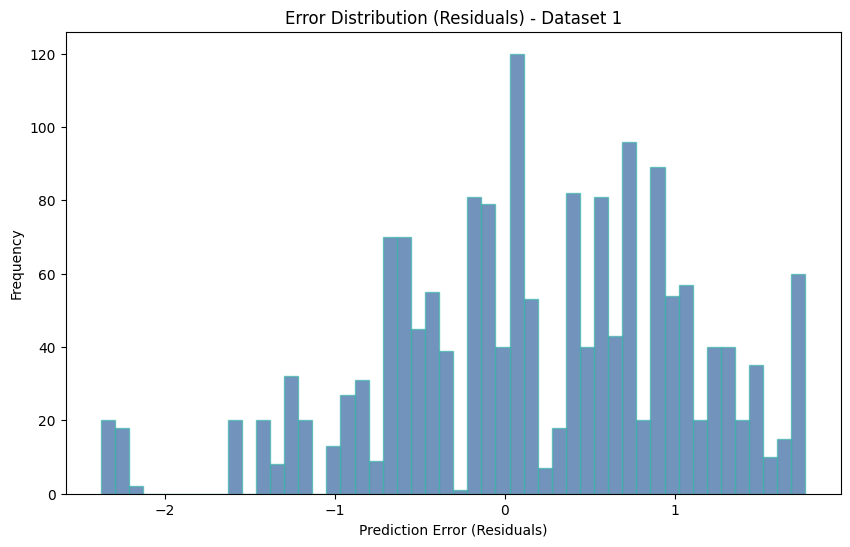

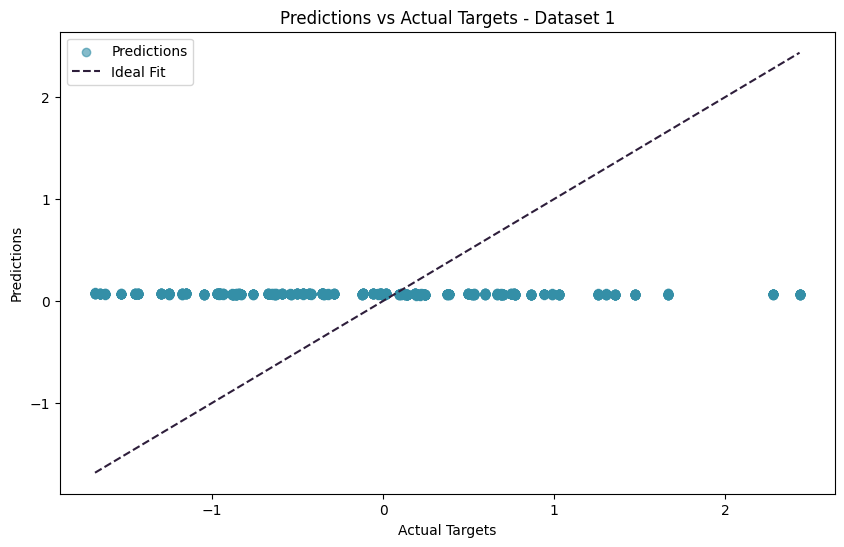

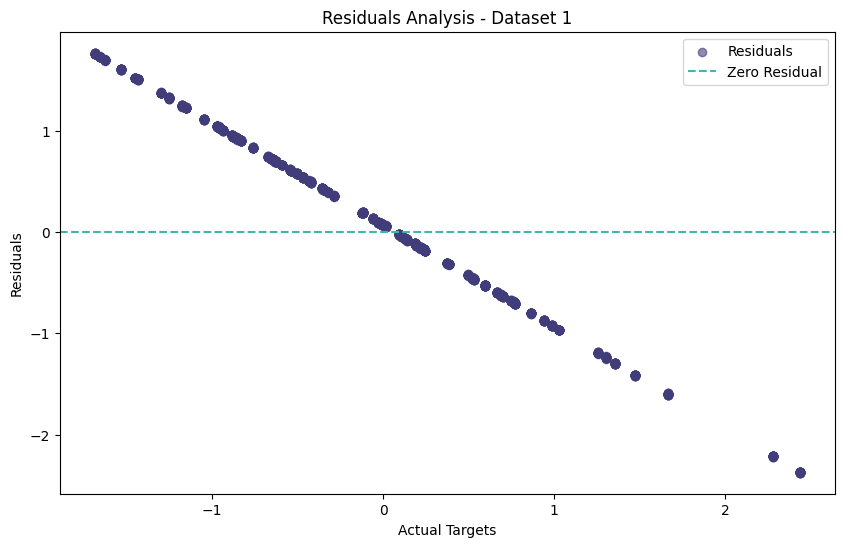

Dataset 1 - Number of Outliers: 85
Dataset 1 - Outlier Threshold: 1.6985
Analyzing Dataset 2...
Dataset 2 - MSE: 0.7780, MAE: 0.7179, R²: 0.0019


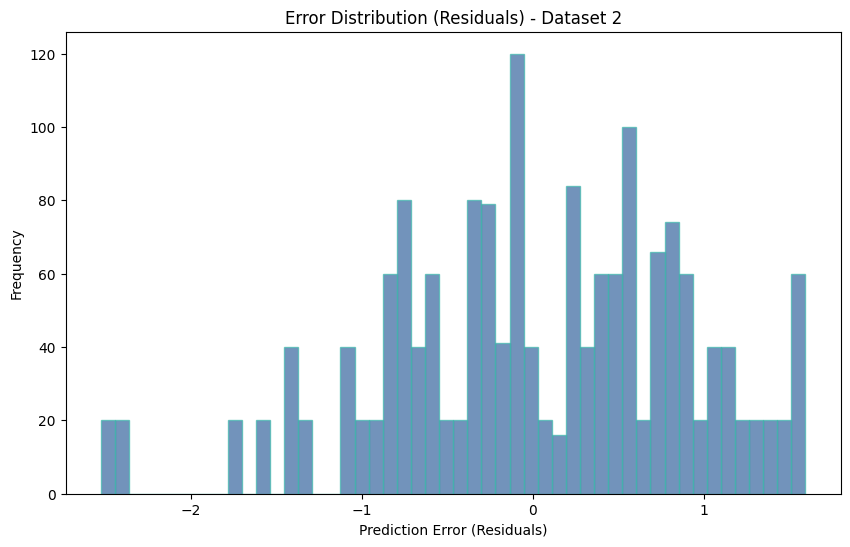

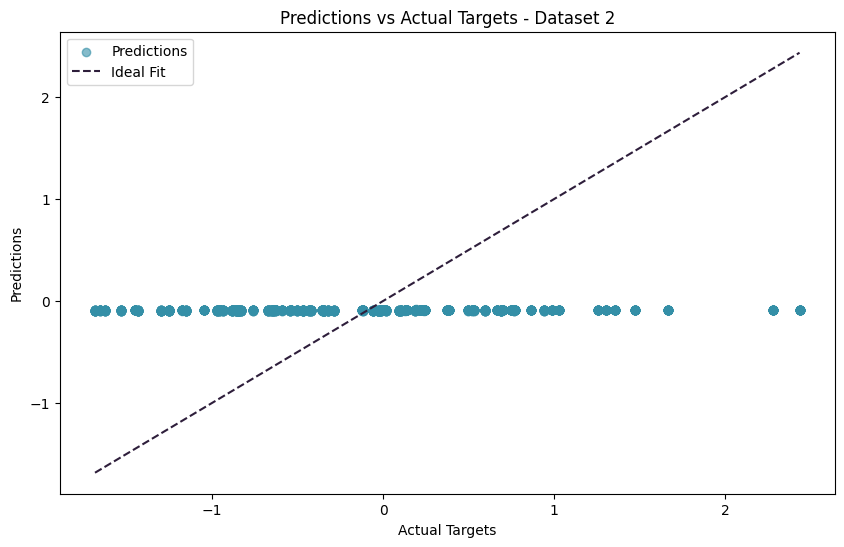

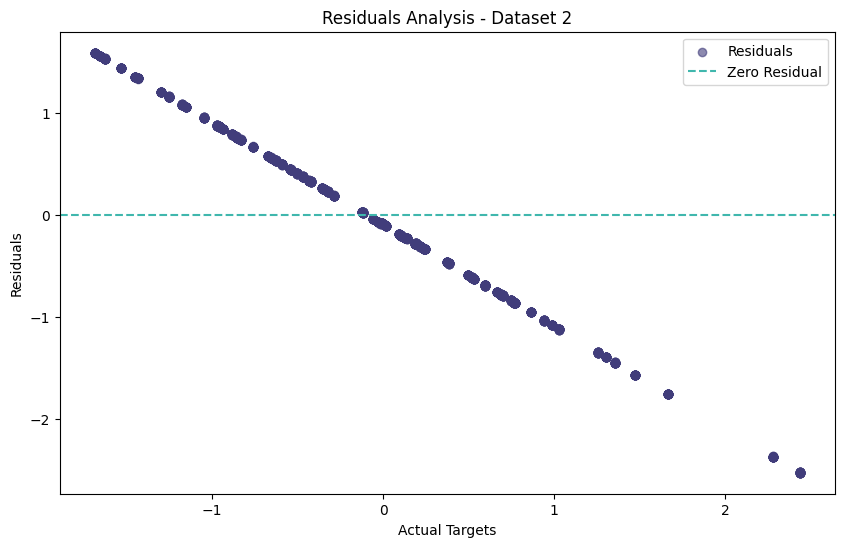

Dataset 2 - Number of Outliers: 85
Dataset 2 - Outlier Threshold: 1.5649


In [38]:
datasets = {
    "Dataset 1": {
        "train": TensorDataset(realsynth_training_images, filtered_withoutYOLO_realsynth_training_vectors, realsynth_training_targets),
        "test": TensorDataset(testing_tensor_images, filtered_withoutYOLO_testing_vectors, testing_target_tensor),
        "model": lambda: CNN(conditioning_dim = filtered_withoutYOLO_realsynth_training_vectors.size(1)).to(device),
    },
    "Dataset 2": {
        "train": TensorDataset(training_tensor_images, filtered_withoutYOLO_training_tensor_vectors, target_tensor),
        "test": TensorDataset(testing_tensor_images, filtered_withoutYOLO_testing_vectors, testing_target_tensor),
        "model": lambda: CNN(conditioning_dim = filtered_withoutYOLO_training_tensor_vectors.size(1)).to(device),
    }
}

sns.set_palette("mako")
def error_analysis(model, loader, criterion, device, dataset_name):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for batch_images, batch_vectors, batch_targets in loader:
            batch_images  = batch_images.to(device)
            batch_vectors = batch_vectors.to(device)
            batch_targets = batch_targets.to(device).squeeze()

            predictions = model(batch_images, batch_vectors).squeeze()
            all_preds.extend(predictions.cpu().numpy())
            all_targets.extend(batch_targets.cpu().numpy())
    all_preds   = np.array(all_preds)
    all_targets = np.array(all_targets)
    residuals   = all_preds - all_targets
    # Metrics
    mse = mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    r2  = r2_score(all_targets, all_preds)
    print(f"{dataset_name} - MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    # Error distribution
    plt.figure(figsize = (10, 6))
    plt.hist(residuals, bins = 50, alpha = 0.7, color = sns.color_palette("mako")[2], edgecolor = sns.color_palette("mako")[4])
    plt.title(f"Error Distribution (Residuals) - {dataset_name}")
    plt.xlabel("Prediction Error (Residuals)")
    plt.ylabel("Frequency")
    plt.show()

    # Predictions against targets
    plt.figure(figsize = (10, 6))
    plt.scatter(all_targets, all_preds, alpha = 0.6, color = sns.color_palette("mako")[3], label = "Predictions")
    plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], color = sns.color_palette("mako")[0], linestyle = "--", label = "Ideal Fit")
    plt.title(f"Predictions vs Actual Targets - {dataset_name}")
    plt.xlabel("Actual Targets")
    plt.ylabel("Predictions")
    plt.legend()
    plt.show()

    # Residuals plot
    plt.figure(figsize = (10, 6))
    plt.scatter(all_targets, residuals, alpha = 0.6, color = sns.color_palette("mako")[1], label = "Residuals")
    plt.axhline(0, color = sns.color_palette("mako")[4], linestyle = "--", label = "Zero Residual")
    plt.title(f"Residuals Analysis - {dataset_name}")
    plt.xlabel("Actual Targets")
    plt.ylabel("Residuals")
    plt.legend()
    plt.show()

    # Outliers detection
    outlier_threshold = np.percentile(np.abs(residuals), 95)
    outliers          = np.where(np.abs(residuals) > outlier_threshold)
    print(f"{dataset_name} - Number of Outliers: {len(outliers[0])}")
    print(f"{dataset_name} - Outlier Threshold: {outlier_threshold:.4f}")

    return all_preds, all_targets, residuals

# Perform error analysis for each dataset
for dataset_name, dataset in datasets.items():
    print(f"Analyzing {dataset_name}...")
    # Create DataLoaders
    train_loader = DataLoader(dataset["train"], batch_size = 64, worker_init_fn = worker_init_fn, num_workers = 0, shuffle = False)
    test_loader  = DataLoader(dataset["test"],  batch_size = 64, worker_init_fn = worker_init_fn, num_workers = 0, shuffle = False)
    # Instantiate model for this dataset
    model = dataset["model"]()
    # Perform error analysis for the test dataset
    preds, targets, residuals = error_analysis(model, test_loader, criterion_huber, device, dataset_name)